# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn import svm
import pickle
from sklearn.linear_model import SGDClassifier, RidgeClassifier, Perceptron, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import NuSVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.kernel_approximation import Nystroem
import os
import matplotlib.patches as mpatch
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Definitions

In [2]:
def data_split(smooth=False):
    data = pd.read_csv("train_selected.csv")
    label=data.pop("label_bnc")
    if smooth:
        sm_s1, sm_s2, sm_s3, sm_s4 = list(),list(),list(),list()
        for engine, group in data.groupby("id"):
            sm_s1.extend(savgol_filter(group["s1"],25,1))
            sm_s2.extend(savgol_filter(group["s2"],25,1))
            sm_s3.extend(savgol_filter(group["s3"],25,1))
            sm_s4.extend(savgol_filter(group["s4"],25,1))
        data["sm_s1"] = sm_s1
        data["sm_s2"] = sm_s2
        data["sm_s3"] = sm_s3
        data["sm_s4"] = sm_s4
        return data[["cycle","sm_s1","sm_s2","sm_s3","sm_s4"]], label
    else:
        return data[["cycle","s1","s2","s3","s4"]], label

def pkl(model, name):
    file = 'classifiers/{}.pkl'.format(name)
    try:
        old = pickle.load(open(file,"rb"))
        old_score = recall_roc(y_val,old.predict(X_val))
        new_score = recall_roc(y_val,model.predict(X_val))
        if new_score > old_score:
            pickle.dump(model, open(file,'wb'))
            print("New best score - model saved.")
        else: 
            print("No improvement observed. Current leading model at {}:\n{}".format(old_score,old))
    except:
        pickle.dump(model, open(file,'wb'))
        print("Model saved")
        
def resultplot(model,name):
    pred_val = model.predict(X_val)
    f, (ax1,ax2) = plt.subplots(ncols=2,
                               figsize=(12,3),
                                gridspec_kw={'width_ratios': [3, 1]})
    y = [int(line) for line in open("PM_truth.txt", "r").readlines()]
    x = range(0,len(y))
    recall = metrics.recall_score(y_val,pred_val,average='binary')
    df = pd.DataFrame(list(zip(y,pred_val)),
                      columns=["ttf","label_bnc"]).sort_values(by="ttf")
    df["x"]=x
    for lname, group in df.groupby("label_bnc"):
        ax1.scatter(group["x"],group["ttf"],label=lname)
    ax1.legend()
    ax1.set_ylabel("Time to Failure")
    ax1.set_title("Classification results: {}\n Weighted Recall: {}".format(name, recall))
    ax1.hlines(y = 30, xmin = 0, xmax = max(x))
    ax1.axes.xaxis.set_visible(False)
    ax1 = plt.gca()

    matrix = pd.DataFrame(metrics.confusion_matrix(y_val,pred_val),
                      index=[0,1],
                      columns=[0,1])
    ax2 = sns.heatmap(matrix, annot=True, fmt="d", cmap="rocket_r")
    ax2.yaxis.set_ticklabels(ax2.yaxis.get_ticklabels(), 
                             rotation=0, ha='right', 
                             fontsize=14)
    ax2.xaxis.set_ticklabels(ax2.xaxis.get_ticklabels(), 
                             rotation=0, ha='right', 
                             fontsize=14)
    ax2.set_ylabel('True label')
    ax2.set_xlabel('Predicted label')
    
    plt.show()
    
def fit_validate(pipeline,params,name,save=True):
    gs = GridSearchCV(pipeline,params,
                  verbose=10,n_jobs=-1,
                 scoring=rocall).fit(X_train,y_train)
    model = gs.best_estimator_
    pred_val = model.predict(X_val)
    print("-----Best Estimator-----\n{}\n-----------".format(model))
    print(metrics.classification_report(y_val,pred_val))
    print("Area under ROC: {}".format(metrics.roc_auc_score(y_val,pred_val)))
    print("Binary Recall: {}".format(metrics.recall_score(y_val,pred_val,average='binary')))
    print("Combined: {}".format(recall_roc(y_val,pred_val)))
    resultplot(model,name)
    if save: pkl(model,name)
        
def assemble_estimators(container,number):
    models, scores = list(),list()
    container = [name for name in container if name not in ["Voter","Stacker", "Voter_Smooth", "Stacker_Smooth"]]
    for name in container:
        file = open(r"classifiers/{}.pkl".format(name),'rb')
        model = pickle.load(file)
        file.close()
        models.append(model)
        scores.append(recall_roc(y_val,model.predict(X_val)))
    leaderboard=pd.DataFrame(list(zip(container, models, scores)), 
               columns =['Name', 'Model', 'Score'])
    leaderboard = leaderboard.sort_values(by="Score", ascending=False).reset_index()
    estimators = list()
    for i in range(number): 
        print(leaderboard["Name"][i])
        estimators.append((leaderboard["Name"][i],leaderboard["Model"][i]))
    return estimators        

X_val = pd.read_csv("test_selected.csv")
X_val.pop('id')
y_val = [int(int(line)<=30) for line in open("PM_truth.txt", "r").readlines()]
    
def recall_roc(y,pred):
    recall = metrics.recall_score(y,pred,average='binary')
    roc = metrics.roc_auc_score(y,pred)
    return 0.5*(roc+recall)

rocall = metrics.make_scorer(recall_roc)

# Linear Discriminant Analysis

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/lxgrf/.venv/j_ML/lib/python3.6/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.880882   0.86522544 0.86909644 0.87218507 0.88108116 0.86896908
 0.86982323 0.87205822 0.88179274 0.87070595 0.87121834 0.87217181
 0.88179274 0.87042124 0.8698946  0.87113279 0.880882   0.86522544
 0.86909644 0.87217081 0.88108116 0.86896908 0.86982323 0.87205822
 0.88179274 0.87070595 0.87121834 0.87215755 0.88179274 0.87042124
 0.8698946  0.87113279 0.880882   0.86522544 0.86909644 0.87217081
 0.88108116 0.86896908 0.86982323 0.87205822 0.88179274 0.87070595
 0.87121834 0.87215755        nan 0.87042124 0.8698946  0.87113279]
  category=UserWarning


-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=5)),
                ('lda', LinearDiscriminantAnalysis())])
-----------
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        75
           1       0.68      0.60      0.64        25

    accuracy                           0.83       100
   macro avg       0.78      0.75      0.76       100
weighted avg       0.82      0.83      0.83       100

Area under ROC: 0.7533333333333334
Binary Recall: 0.6
Combined: 0.6766666666666667


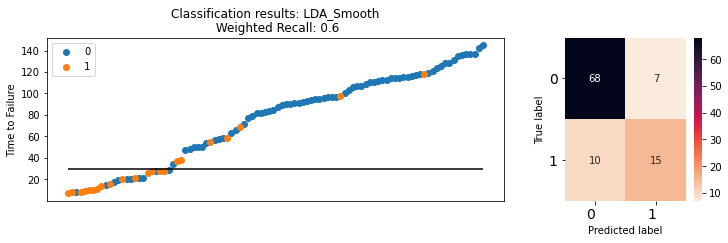

No improvement observed. Current leading model at 0.6866666666666668:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('lda', LinearDiscriminantAnalysis())])
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/lxgrf/.venv/j_ML/lib/python3.6/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.84752043 0.84797575 0.83993434 0.83202074 0.84767679 0.8474491
 0.8475199  0.84572653 0.84929952 0.84790445 0.84783314 0.82827862
 0.84929952 0.82695484 0.82712598 0.82867743 0.84752043 0.84797575
 0.83993434 0.83226268 0.84767679 0.8474491  0.8475199  0.84571227
 0.84929952 0.84790445 0.84783314 0.82852056 0.84929952 0.82695484
 0.82712598 0.82867743 0.84752043 0.84797575 0.83993434 0.83226268
 0.84767679 0.8474491  0.8475199  0.84571227 0.84929952 0.84790445
 0.84783314 0.82852056        nan 0.82695484 0.82712598 0.82867743]
  category=UserWarning


-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=5)),
                ('lda', LinearDiscriminantAnalysis())])
-----------
              precision    recall  f1-score   support

           0       0.90      0.97      0.94        75
           1       0.89      0.68      0.77        25

    accuracy                           0.90       100
   macro avg       0.90      0.83      0.85       100
weighted avg       0.90      0.90      0.90       100

Area under ROC: 0.8266666666666668
Binary Recall: 0.68
Combined: 0.7533333333333334


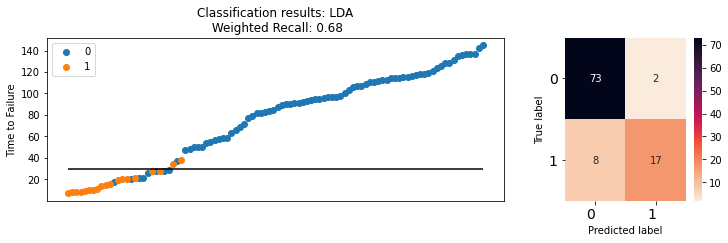

No improvement observed. Current leading model at 0.7533333333333334:
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('lda', LinearDiscriminantAnalysis())])


In [4]:
pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('lda', LinearDiscriminantAnalysis()),
    ])

params = {
    'pca__n_components': (3,4,5,6),
    'pfs__degree':(1,2,3,4),
    'lda__solver':('svd','lsqr','eigen')
    }

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"LDA_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"LDA")

# Bernoulli Naive Bayes

Fitting 5 folds for each of 16 candidates, totalling 80 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)), ('bnb', BernoulliNB())])
-----------
              precision    recall  f1-score   support

           0       0.91      0.85      0.88        75
           1       0.63      0.76      0.69        25

    accuracy                           0.83       100
   macro avg       0.77      0.81      0.79       100
weighted avg       0.84      0.83      0.83       100

Area under ROC: 0.8066666666666666
Binary Recall: 0.76
Combined: 0.7833333333333333


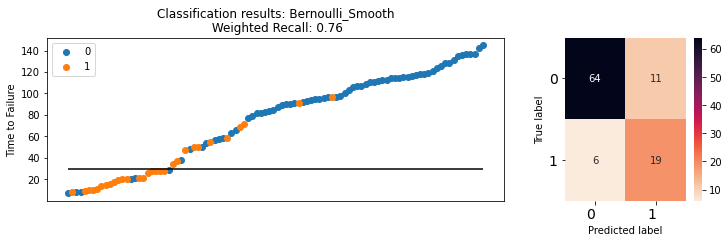

No improvement observed. Current leading model at 0.7833333333333333:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)), ('bnb', BernoulliNB())])
Fitting 5 folds for each of 16 candidates, totalling 80 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=5)), ('bnb', BernoulliNB())])
-----------
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        75
           1       0.76      0.52      0.62        25

    accuracy                           0.84       100
   macro avg       0.81      0.73      0.76       100
weighted avg       0.83      0.84      0.83       100

Area under ROC: 0.7333333333333334
Binary Recall: 0.52
Combined: 0.6266666666666667


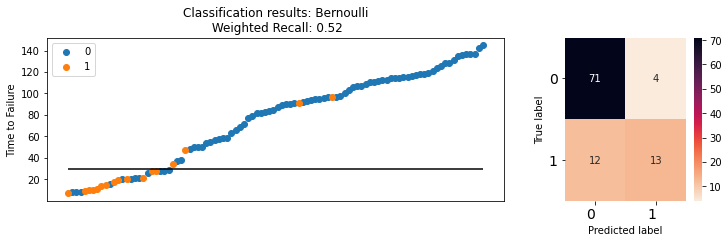

New best score - model saved.


In [4]:
pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('bnb', BernoulliNB()),
    ])

params = {
    'pca__n_components': (3,4,5,6),
    'pfs__degree':(1,2,3,4),
    }

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"Bernoulli_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"Bernoulli")

# Logistic Regression

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/home/lxgrf/.venv/j_ML/lib/python3.6/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.86508742 0.86740698
 0.87453771 0.87647319 0.86517299 0.86985533 0.86935721 0.8747939
 0.86763571 0.87721331 0.87600364 0.87577597 0.86763571 0.87300059
 0.87374066 0.87325679        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.94146024 0.94355004
 0.94635495 0.94905955 0.94073393 0.94723863 0.94715358 0.94830676
 0.94118982 0.94605705 0.94601428 0.9458294  0

-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('log', LogisticRegression(class_weight='balanced'))])
-----------
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        75
           1       0.74      0.80      0.77        25

    accuracy                           0.88       100
   macro avg       0.84      0.85      0.84       100
weighted avg       0.88      0.88      0.88       100

Area under ROC: 0.8533333333333333
Binary Recall: 0.8
Combined: 0.8266666666666667


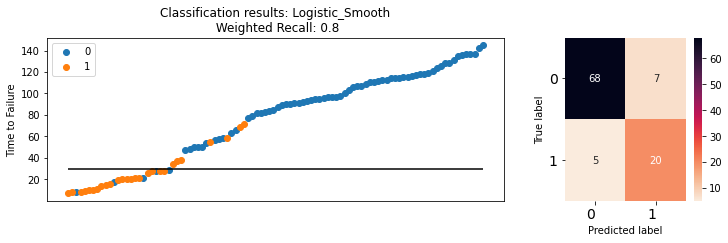

No improvement observed. Current leading model at 0.8266666666666667:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('log', LogisticRegression(class_weight='balanced'))])
Fitting 5 folds for each of 96 candidates, totalling 480 fits


/home/lxgrf/.venv/j_ML/lib/python3.6/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.82915061 0.83225347
 0.82836774 0.82052597 0.82936402 0.83026096 0.83044586 0.83023244
 0.83196876 0.83149915 0.83101529 0.8366939  0.83196876 0.83870069
 0.83720629 0.83764738        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.9257667  0.92727539
 0.92556665 0.91975873 0.92504088 0.92673449 0.92588083 0.92657811
 0.92606522 0.92565265 0.92551054 0.93432056 

-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=6)),
                ('log', LogisticRegression(class_weight='balanced'))])
-----------
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        75
           1       0.74      0.80      0.77        25

    accuracy                           0.88       100
   macro avg       0.84      0.85      0.84       100
weighted avg       0.88      0.88      0.88       100

Area under ROC: 0.8533333333333333
Binary Recall: 0.8
Combined: 0.8266666666666667


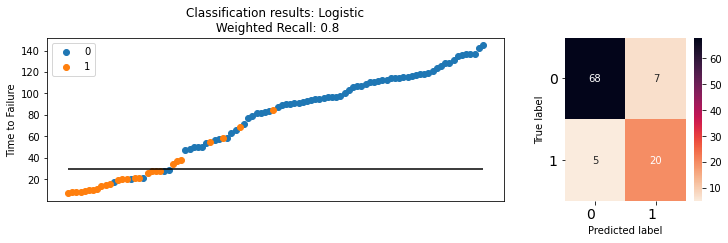

New best score - model saved.


In [5]:
pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('log', LogisticRegression()),
    ])

params = {
    'pca__n_components': (3,4,5,6),
    'pfs__degree':(1,2,3,4),
    'log__class_weight':(None,'balanced'),
    'log__penalty':('l1','l2','elasticnet')
    }

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"Logistic_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"Logistic")

# Ridge

Fitting 5 folds for each of 112 candidates, totalling 560 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=6)),
                ('rdg', RidgeClassifier(solver='saga'))])
-----------
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        75
           1       0.70      0.56      0.62        25

    accuracy                           0.83       100
   macro avg       0.78      0.74      0.76       100
weighted avg       0.82      0.83      0.82       100

Area under ROC: 0.74
Binary Recall: 0.56
Combined: 0.65


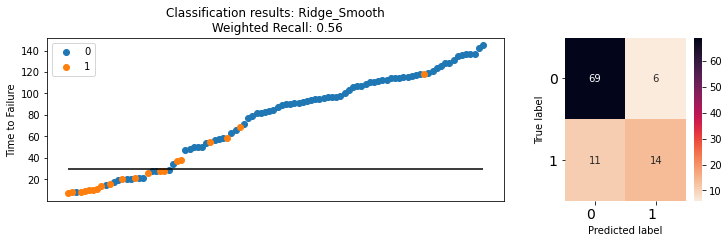

No improvement observed. Current leading model at 0.6533333333333334:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('rdg', RidgeClassifier(solver='sag'))])
Fitting 5 folds for each of 112 candidates, totalling 560 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=5)), ('rdg', RidgeClassifier())])
-----------
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        75
           1       0.93      0.56      0.70        25

    accuracy                           0.88       100
   macro avg       0.90      0.77      0.81       100
weighted avg       0.89      0.88      0.87       100

Area under ROC: 0.7733333333333334
Binary Recall: 0.56
Combined: 0.6666666666666667


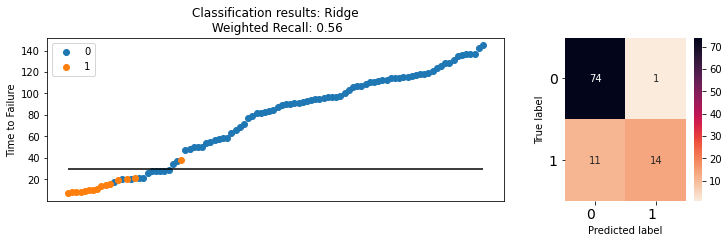

New best score - model saved.


In [6]:
pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('rdg', RidgeClassifier()),
    ])

params = {
    'pca__n_components': (3,4,5,6),
    'pfs__degree':(1,2,3,4),
    'rdg__solver':('auto','svd','cholesky','lsqr','sparse_cg','sag','saga')
    }

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"Ridge_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"Ridge")

# KNN

Fitting 5 folds for each of 96 candidates, totalling 480 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)), ('ss2', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=1))])
-----------
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        75
           1       0.64      0.84      0.72        25

    accuracy                           0.84       100
   macro avg       0.79      0.84      0.81       100
weighted avg       0.86      0.84      0.85       100

Area under ROC: 0.84
Binary Recall: 0.84
Combined: 0.84


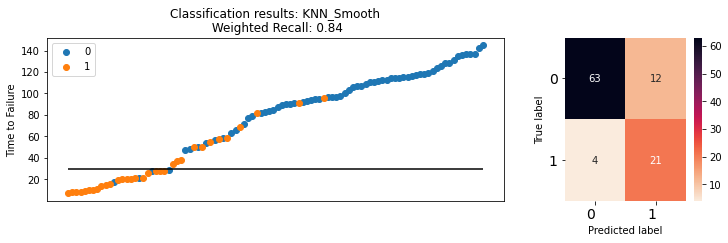

No improvement observed. Current leading model at 0.8633333333333333:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('knn', KNeighborsClassifier(n_neighbors=1))])
Fitting 5 folds for each of 96 candidates, totalling 480 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)), ('ss2', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=1))])
-----------
              precision    recall  f1-score   support

           0       0.88      0.99      0.93        75
           1       0.94      0.60      0.73        25

    accuracy                           0.89       100
   macro avg       0.91      0.79      0.83       100
weighted avg       0.90      0.89      0.88       100

Area under ROC: 0.7933333333333334
Binary Recall: 0.6
Combined: 0.6966666666666668


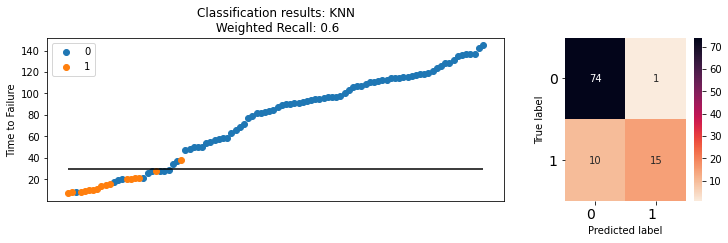

No improvement observed. Current leading model at 0.75:
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('knn', KNeighborsClassifier(n_neighbors=10))])


In [7]:
pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('ss2', StandardScaler()),
    ('knn', KNeighborsClassifier()),
    ])

params = {
    'pca__n_components': (3,4,5,6),
    'pfs__degree':(1,2,3,4),
    'knn__weights': ('uniform','distance'),
    'knn__n_neighbors': ([1]),
    'knn__algorithm':('auto','ball_tree','kd_tree'),
    #'knn__metric':('minkowski','euclidean','manhattan','chebyshev'),
    #'knn__p':(1,2,3),
    }

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"KNN_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"KNN")

# Radius Neighbours

Fitting 5 folds for each of 192 candidates, totalling 960 fits


/home/lxgrf/.venv/j_ML/lib/python3.6/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.84637529 0.84772709 0.82810322 0.84135215 0.7895091  0.82125822
 0.84637529 0.84772709 0.82810322 0.84135215 0.7895091  0.82125822
        nan        nan 0.84866631 0.84971813 0.84722942 0.84816766
        nan        nan 0.84866631 0.84971813 0.84722942 0.84816766
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.84660296 0.847286   0.82860135 0.8406406  0.79000723 0.82006281
 0.84660296 0.847286   0.82860135 0.8406406  0.79000723 0.82006281
        nan        nan 0.84636104 0.84570605 0.84515183 0.84613335
        nan        nan 0.84636104 0.84570605 0.84515183 0.84613335
        nan        nan        nan        nan 

-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('rnn',
                 RadiusNeighborsClassifier(algorithm='ball_tree', radius=1.5,
                                           weights='distance'))])
-----------
              precision    recall  f1-score   support

           0       0.90      0.97      0.94        75
           1       0.89      0.68      0.77        25

    accuracy                           0.90       100
   macro avg       0.90      0.83      0.85       100
weighted avg       0.90      0.90      0.90       100

Area under ROC: 0.8266666666666668
Binary Recall: 0.68
Combined: 0.7533333333333334


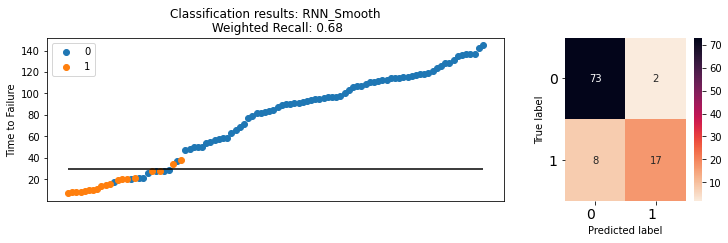

No improvement observed. Current leading model at 0.7533333333333334:
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('rnn',
                 RadiusNeighborsClassifier(radius=2, weights='distance'))])
Fitting 5 folds for each of 192 candidates, totalling 960 fits


/home/lxgrf/.venv/j_ML/lib/python3.6/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.81810914 0.81904837 0.80284064 0.81049653 0.75163835 0.78577779
 0.81810914 0.81904837 0.80284064 0.81049653 0.75163835 0.78577779
        nan        nan        nan        nan 0.8192057  0.82142542
        nan        nan        nan        nan 0.8192057  0.82142542
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.8064977  0.81139297 0.7627241  0.78465368
        nan        nan 0.8064977  0.81139297 0.7627241  0.78465368
        nan        nan        nan        nan 0.82087024 0.8229621
        nan        nan        nan        nan 0.82087024 0.8229621
        nan        nan        nan        nan   

-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('rnn',
                 RadiusNeighborsClassifier(algorithm='ball_tree', radius=2,
                                           weights='distance'))])
-----------
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        75
           1       0.89      0.64      0.74        25

    accuracy                           0.89       100
   macro avg       0.89      0.81      0.84       100
weighted avg       0.89      0.89      0.88       100

Area under ROC: 0.8066666666666668
Binary Recall: 0.64
Combined: 0.7233333333333334


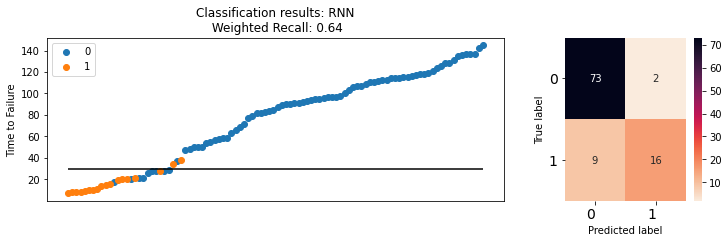

No improvement observed. Current leading model at 0.7533333333333334:
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('rnn',
                 RadiusNeighborsClassifier(radius=1.5, weights='distance'))])


In [3]:
pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('rnn', RadiusNeighborsClassifier()),
    ])

params = {
    'pca__n_components': (3,4,5,6),
    'pfs__degree':(1,2,3,4),
    'rnn__weights': ('uniform','distance'),
    #'rnn__n_neighbors': (1,5,10),
    'rnn__algorithm':('ball_tree','kd_tree'),
    'rnn__radius':(1,1.5,2),
    }

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"RNN_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"RNN")

# Linear SVC

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/home/lxgrf/.venv/j_ML/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=5)), ('lsv', LinearSVC())])
-----------
              precision    recall  f1-score   support

           0       0.87      0.92      0.90        75
           1       0.71      0.60      0.65        25

    accuracy                           0.84       100
   macro avg       0.79      0.76      0.77       100
weighted avg       0.83      0.84      0.84       100

Area under ROC: 0.7600000000000001
Binary Recall: 0.6
Combined: 0.68


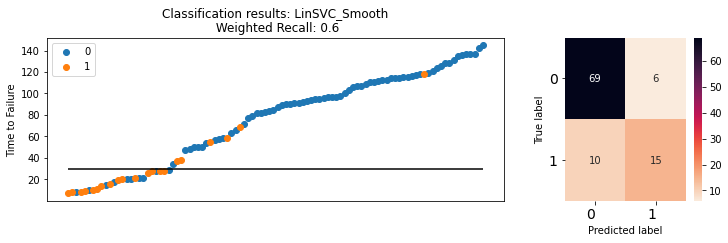

No improvement observed. Current leading model at 0.7166666666666668:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)), ('lsv', LinearSVC())])
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/home/lxgrf/.venv/j_ML/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=5)), ('lsv', LinearSVC())])
-----------
              precision    recall  f1-score   support

           0       0.90      0.97      0.94        75
           1       0.89      0.68      0.77        25

    accuracy                           0.90       100
   macro avg       0.90      0.83      0.85       100
weighted avg       0.90      0.90      0.90       100

Area under ROC: 0.8266666666666668
Binary Recall: 0.68
Combined: 0.7533333333333334


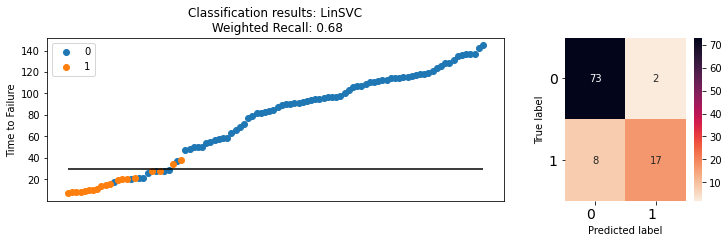

No improvement observed. Current leading model at 0.7533333333333334:
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=2)), ('lsv', LinearSVC())])


In [4]:
pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    #('nys', Nystroem()),
    ('lsv', svm.LinearSVC()),
    ])

params = {
    'pca__n_components': (3,4,5,6),
    'pfs__degree':(1,2,3,4),
    'lsv__loss':('hinge','squared_hinge')
    }

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"LinSVC_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"LinSVC")

# SVM

Fitting 5 folds for each of 160 candidates, totalling 800 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('svc', SVC(C=0.6, class_weight='balanced'))])
-----------
              precision    recall  f1-score   support

           0       0.96      0.91      0.93        75
           1       0.76      0.88      0.81        25

    accuracy                           0.90       100
   macro avg       0.86      0.89      0.87       100
weighted avg       0.91      0.90      0.90       100

Area under ROC: 0.8933333333333333
Binary Recall: 0.88
Combined: 0.8866666666666667


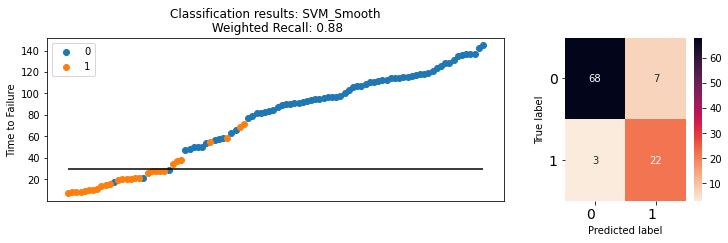

No improvement observed. Current leading model at 0.8866666666666667:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('svc', SVC(C=0.6, class_weight='balanced'))])
Fitting 5 folds for each of 160 candidates, totalling 800 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=5)),
                ('svc', SVC(C=0.6, class_weight='balanced'))])
-----------
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        75
           1       0.70      0.84      0.76        25

    accuracy                           0.87       100
   macro avg       0.82      0.86      0.84       100
weighted avg       0.88      0.87      0.87       100

Area under ROC: 0.86
Binary Recall: 0.84
Combined: 0.85


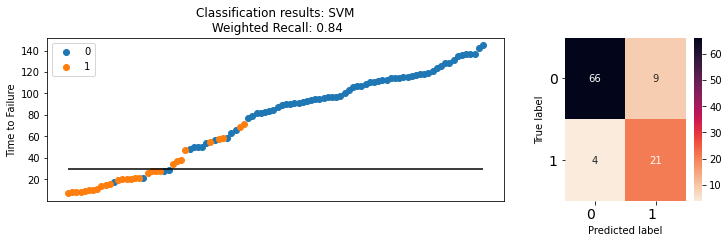

No improvement observed. Current leading model at 0.8533333333333333:
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('svc', SVC(C=0.7, class_weight='balanced'))])


In [5]:
from sklearn.kernel_approximation import Nystroem

pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    #('nys', Nystroem()),
    ('svc', svm.SVC()),
])

params = {
    'pca__n_components': (3,4,5,6),
    'pfs__degree':(1,2,3,4),
    #'svc__kernel':('linear','rbf','sigmoid'),
    'svc__C':(0.5,0.6,0.7,0.8,0.9),
    #'nys__gamma':(0.1,0.2,0.3),
    'svc__class_weight':(None,'balanced')
}


X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"SVM_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"SVM")

# NuSVM

Fitting 5 folds for each of 112 candidates, totalling 560 fits


/home/lxgrf/.venv/j_ML/lib/python3.6/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.85360307 0.58917982 0.70094968 0.73971806 0.86718837 0.86380991
 0.85570034 0.87930645 0.862602   0.86445167 0.8558331  0.8599008
 0.862602   0.85861621 0.86546717 0.8387978  0.84966309 0.84311658
 0.85010418 0.85302117 0.84892303 0.84996156 0.85302116 0.85731947
 0.85053104 0.85330592 0.85521288 0.8572482  0.85053104 0.85258011
 0.85424514 0.85770354 0.84502349 0.85057375 0.85313523 0.8555831
 0.84452536 0.85102911 0.85309245 0.85610976 0.84429769 0.85131383
 0.85384677 0.85750434 0.84429769 0.85131383 0.85384678 0.85729092
 0.83527574 0.83869136 0.82555605 0.82522904 0.83526148 0.83843516
 0.82531412 0.82685129 0.8350338  0.8386771  0.82554179 0.82683703
 0.8350338  0.8386771  0.82554179 0.82683703 0.824546   0.80923377
 0.80738384 0.80327144 0.82525755 0.80991679 0.80828028 0.80705684
 0.82594057 0.81158182 0.80948995 0.80702832 0.

-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('nsvc', NuSVC(class_weight='balanced', nu=0.05))])
-----------
              precision    recall  f1-score   support

           0       0.93      0.92      0.93        75
           1       0.77      0.80      0.78        25

    accuracy                           0.89       100
   macro avg       0.85      0.86      0.86       100
weighted avg       0.89      0.89      0.89       100

Area under ROC: 0.8600000000000001
Binary Recall: 0.8
Combined: 0.8300000000000001


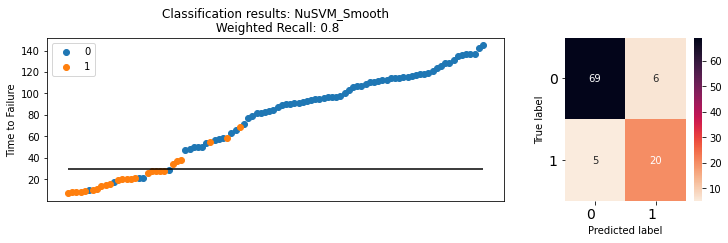

No improvement observed. Current leading model at 0.8300000000000001:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('nsvc', NuSVC(class_weight='balanced', nu=0.05))])
Fitting 5 folds for each of 112 candidates, totalling 560 fits


/home/lxgrf/.venv/j_ML/lib/python3.6/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.33423996 0.59420864 0.42147272 0.29872555 0.57856541 0.60165845
 0.58964646 0.56386527 0.59163358 0.70655005 0.70952069 0.70260021
 0.59163358 0.688464   0.80140302 0.68943863 0.77897403 0.84221397
 0.80200206 0.72197873 0.7926378  0.79732265 0.82189166 0.81414941
 0.81454203 0.823215   0.80925242 0.82469605 0.81454203 0.81978307
 0.82162117 0.81601534 0.81634479 0.82042966 0.81889196 0.81372573
 0.81657246 0.82017346 0.82338942 0.82373067 0.81884971 0.82168211
 0.82476973 0.82270589 0.81884971 0.82218024 0.82454205 0.82321828
 0.80695306 0.8091167  0.79886985 0.79135508 0.80648345 0.80878921
 0.80343809 0.79511245 0.80706715 0.80860431 0.80510312 0.79129853
 0.80706715 0.80763657 0.79717629 0.79272162 0.7950992  0.78094009
 0.77020936 0.76091599 0.79413146 0.78158034 0.76983958 0.76393329
 0.79508494 0.78207846 0.76983958 0.7615282  

-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('nsvc', NuSVC(class_weight='balanced', nu=0.1))])
-----------
              precision    recall  f1-score   support

           0       0.96      0.95      0.95        75
           1       0.85      0.88      0.86        25

    accuracy                           0.93       100
   macro avg       0.90      0.91      0.91       100
weighted avg       0.93      0.93      0.93       100

Area under ROC: 0.9133333333333332
Binary Recall: 0.88
Combined: 0.8966666666666666


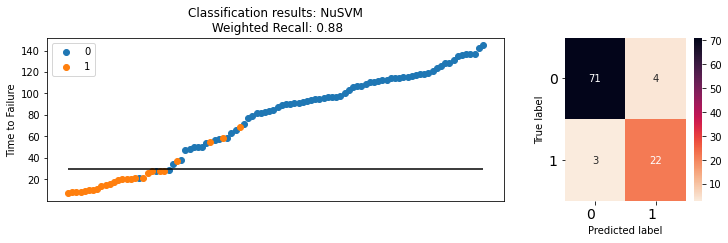

No improvement observed. Current leading model at 0.8966666666666666:
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('nsvc', NuSVC(class_weight='balanced', nu=0.1))])


In [6]:
from sklearn.svm import NuSVC

pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    #('nys', Nystroem()),
    ('nsvc', svm.NuSVC()),
])

params = {
    'pca__n_components': (3,4,5,6),
    'pfs__degree':(1,2,3,4),
    #'nsvc__nu':(0.1,0.2,0.3),
    'nsvc__nu':([i/20 for i in range(1,8,1)]),
    'nsvc__class_weight':(['balanced'])
}

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"NuSVM_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"NuSVM")

# SGD

Fitting 5 folds for each of 80 candidates, totalling 400 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=5)),
                ('sgd', SGDClassifier(loss='perceptron'))])
-----------
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        75
           1       0.76      0.52      0.62        25

    accuracy                           0.84       100
   macro avg       0.81      0.73      0.76       100
weighted avg       0.83      0.84      0.83       100

Area under ROC: 0.7333333333333334
Binary Recall: 0.52
Combined: 0.6266666666666667


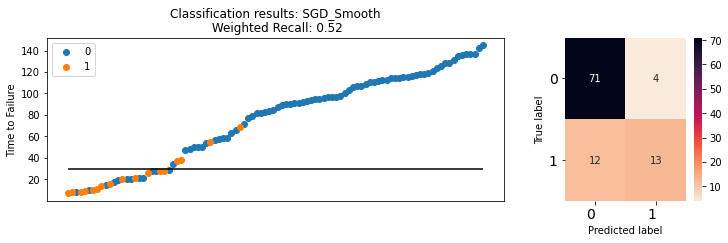

No improvement observed. Current leading model at 0.6833333333333333:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('sgd', SGDClassifier(loss='modified_huber'))])
Fitting 5 folds for each of 80 candidates, totalling 400 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('sgd', SGDClassifier(loss='perceptron'))])
-----------
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        75
           1       0.93      0.56      0.70        25

    accuracy                           0.88       100
   macro avg       0.90      0.77      0.81       100
weighted avg       0.89      0.88      0.87       100

Area under ROC: 0.7733333333333334
Binary Recall: 0.56
Combined: 0.6666666666666667


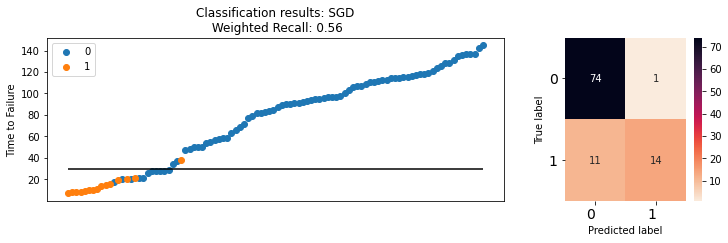

No improvement observed. Current leading model at 0.7233333333333334:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)), ('sgd', SGDClassifier())])


In [7]:
pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('sgd', SGDClassifier()),
])

params = {
    'pca__n_components': (3,4,5,6),
    'pfs__degree':(1,2,3,4),
    'sgd__loss':("hinge", "log", "modified_huber", "squared_hinge", "perceptron"),
}

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"SGD_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"SGD")

# Perceptron

Fitting 5 folds for each of 16 candidates, totalling 80 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)), ('per', Perceptron())])
-----------
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        75
           1       0.68      0.76      0.72        25

    accuracy                           0.85       100
   macro avg       0.80      0.82      0.81       100
weighted avg       0.86      0.85      0.85       100

Area under ROC: 0.82
Binary Recall: 0.76
Combined: 0.79


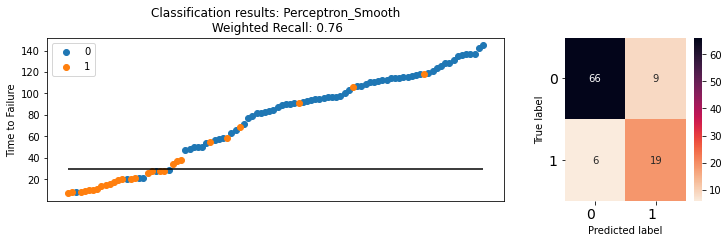

No improvement observed. Current leading model at 0.79:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)), ('per', Perceptron())])
Fitting 5 folds for each of 16 candidates, totalling 80 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=6)), ('per', Perceptron())])
-----------
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        75
           1       0.78      0.72      0.75        25

    accuracy                           0.88       100
   macro avg       0.85      0.83      0.84       100
weighted avg       0.88      0.88      0.88       100

Area under ROC: 0.8266666666666667
Binary Recall: 0.72
Combined: 0.7733333333333333


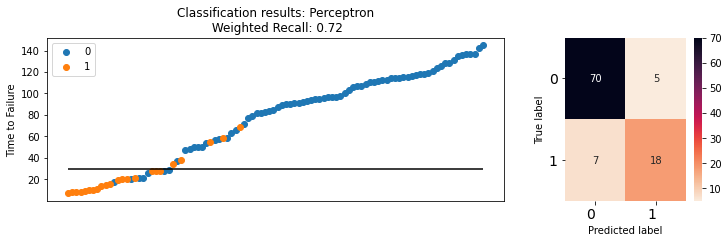

New best score - model saved.


In [8]:
pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('per', Perceptron()),
])

params = {
    'pca__n_components': (3,4,5,6),
    'pfs__degree':(1,2,3,4),
    }

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"Perceptron_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"Perceptron")

# RFC

Fitting 5 folds for each of 32 candidates, totalling 160 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures()),
                ('rfc',
                 RandomForestClassifier(criterion='entropy', max_depth=1))])
-----------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        75
           1       0.76      0.64      0.70        25

    accuracy                           0.86       100
   macro avg       0.82      0.79      0.80       100
weighted avg       0.86      0.86      0.86       100

Area under ROC: 0.7866666666666667
Binary Recall: 0.64
Combined: 0.7133333333333334


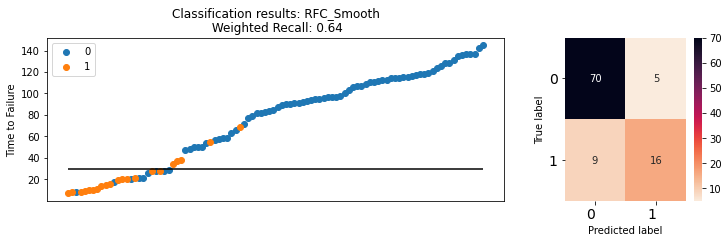

No improvement observed. Current leading model at 0.8:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)),
                ('etc', ExtraTreesClassifier(max_depth=15))])
Fitting 5 folds for each of 32 candidates, totalling 160 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)),
                ('rfc',
                 RandomForestClassifier(criterion='entropy', max_depth=1))])
-----------
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        75
           1       0.77      0.68      0.72        25

    accuracy                           0.87       100
   macro avg       0.84      0.81      0.82       100
weighted avg       0.87      0.87      0.87       100

Area under ROC: 0.8066666666666669
Binary Recall: 0.68
Combined: 0.7433333333333334


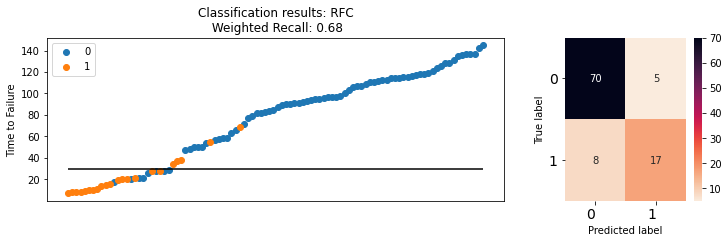

No improvement observed. Current leading model at 0.7533333333333334:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)),
                ('rfc', RandomForestClassifier(max_depth=5, n_estimators=200))])


In [104]:
pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    #('ss', StandardScaler()),
    #('pca', PCA()),
    ('rfc', RandomForestClassifier()),
])

params = {
    #'pca__n_components': (1,2,3,4),
    'pfs__degree':(1,2,3,4),
    'rfc__criterion':('gini','entropy'),
    'rfc__max_depth':(1,5,10,15),
    #'rfc__n_estimators':(100,200,300)
}

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"RFC_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"RFC")

# Extra Trees

Fitting 5 folds for each of 32 candidates, totalling 160 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA()), ('etc', ExtraTreesClassifier(max_depth=15))])
-----------
              precision    recall  f1-score   support

           0       0.92      0.91      0.91        75
           1       0.73      0.76      0.75        25

    accuracy                           0.87       100
   macro avg       0.82      0.83      0.83       100
weighted avg       0.87      0.87      0.87       100

Area under ROC: 0.8333333333333333
Binary Recall: 0.76
Combined: 0.7966666666666666


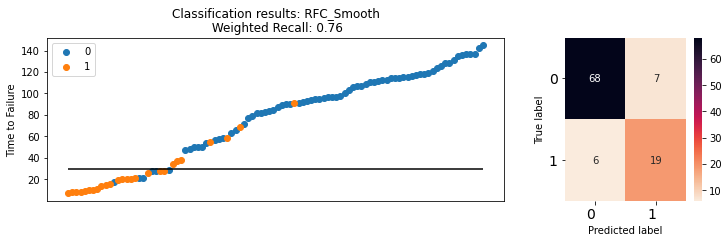

No improvement observed. Current leading model at 0.8:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)),
                ('etc', ExtraTreesClassifier(max_depth=15))])
Fitting 5 folds for each of 32 candidates, totalling 160 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA()),
                ('etc',
                 ExtraTreesClassifier(criterion='entropy', max_depth=15))])
-----------
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        75
           1       0.88      0.60      0.71        25

    accuracy                           0.88       100
   macro avg       0.88      0.79      0.82       100
weighted avg       0.88      0.88      0.87       100

Area under ROC: 0.7866666666666667
Binary Recall: 0.6
Combined: 0.6933333333333334


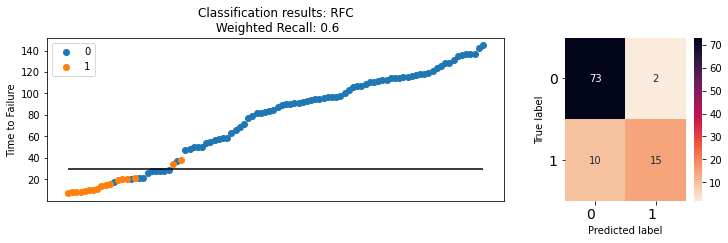

No improvement observed. Current leading model at 0.7533333333333334:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)),
                ('rfc', RandomForestClassifier(max_depth=5, n_estimators=200))])


In [105]:
pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('etc', ExtraTreesClassifier()),
])

params = {
    #'pca__n_components': (1,2,3,4),
    'pfs__degree':(1,2,3,4),
    'etc__criterion':('gini','entropy'),
    'etc__max_depth':(1,5,10,15),
    #'etc__n_estimators':(100,200,300)
}

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"RFC_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"RFC")

# Tree

Fitting 5 folds for each of 1 candidates, totalling 5 fits
-----Best Estimator-----
Pipeline(steps=[('tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=1,
                                        max_features='log2',
                                        min_samples_leaf=13))])
-----------
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        75
           1       0.72      0.72      0.72        25

    accuracy                           0.86       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.86      0.86      0.86       100

Area under ROC: 0.8133333333333332
Binary Recall: 0.72
Combined: 0.7666666666666666


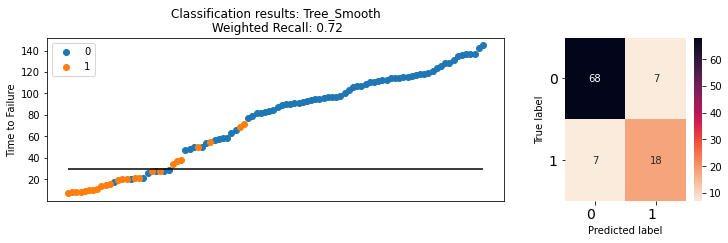

No improvement observed. Current leading model at 0.8233333333333334:
Pipeline(steps=[('pfs', PolynomialFeatures()),
                ('tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=1,
                                        max_features='log2',
                                        min_samples_leaf=9))])
Fitting 5 folds for each of 1 candidates, totalling 5 fits
-----Best Estimator-----
Pipeline(steps=[('tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=1,
                                        max_features='log2',
                                        min_samples_leaf=13))])
-----------
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        75
           1       0.71      0.80      0.75        25

    accuracy                           0.87       100
   macro avg       0.82      0.85      0.83       100
weighted avg       0.88      0.87      0.87       100

Area under RO

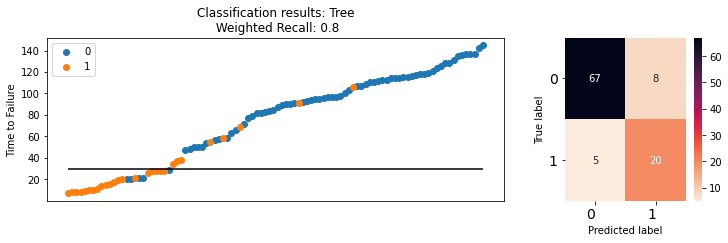

No improvement observed. Current leading model at 0.8233333333333334:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)),
                ('tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=1,
                                        max_features='log2',
                                        min_samples_leaf=13))])


In [106]:
pipeline = Pipeline([
    #('pfs', PolynomialFeatures()),
    #('ss', StandardScaler()),
    #('pca', PCA()),
    ('tree', DecisionTreeClassifier()),
    
        ])

params = {
    #'pfs__degree':(1,2,3,4,5),
    'tree__max_depth':([1]),
    'tree__criterion':(['entropy']),
    'tree__max_features':(['log2']),
    'tree__min_samples_leaf':([13])
}

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"Tree_Smooth")

X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"Tree")

# Ada

Fitting 5 folds for each of 16 candidates, totalling 80 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)), ('ada', AdaBoostClassifier())])
-----------
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        75
           1       0.70      0.84      0.76        25

    accuracy                           0.87       100
   macro avg       0.82      0.86      0.84       100
weighted avg       0.88      0.87      0.87       100

Area under ROC: 0.86
Binary Recall: 0.84
Combined: 0.85


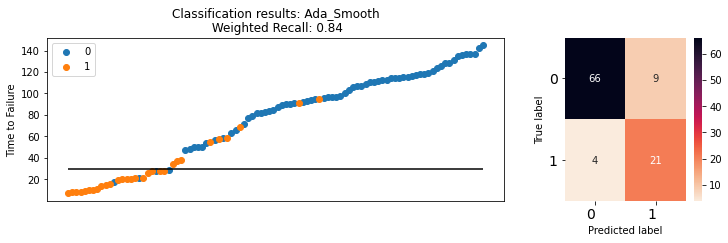

No improvement observed. Current leading model at 0.85:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)), ('ada', AdaBoostClassifier())])
Fitting 5 folds for each of 16 candidates, totalling 80 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)), ('ada', AdaBoostClassifier())])
-----------
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        75
           1       0.89      0.64      0.74        25

    accuracy                           0.89       100
   macro avg       0.89      0.81      0.84       100
weighted avg       0.89      0.89      0.88       100

Area under ROC: 0.8066666666666668
Binary Recall: 0.64
Combined: 0.7233333333333334


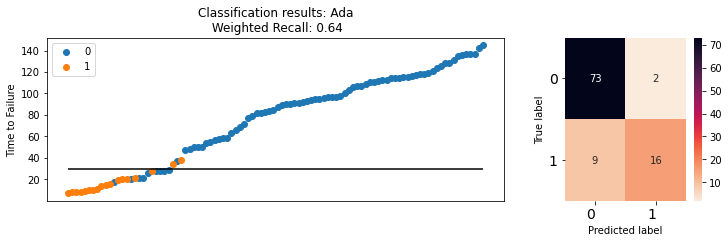

No improvement observed. Current leading model at 0.7233333333333334:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=2)), ('ada', AdaBoostClassifier())])


In [9]:
pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('ada', AdaBoostClassifier()),
])

params = {
    'pca__n_components': (3,4,5,6),
    'pfs__degree':(1,2,3,4),
}

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"Ada_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"Ada")

# Gaussian Naive Bayes

Fitting 5 folds for each of 16 candidates, totalling 80 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)), ('gnb', GaussianNB())])
-----------
              precision    recall  f1-score   support

           0       0.93      0.69      0.79        75
           1       0.48      0.84      0.61        25

    accuracy                           0.73       100
   macro avg       0.70      0.77      0.70       100
weighted avg       0.82      0.73      0.75       100

Area under ROC: 0.7666666666666667
Binary Recall: 0.84
Combined: 0.8033333333333333


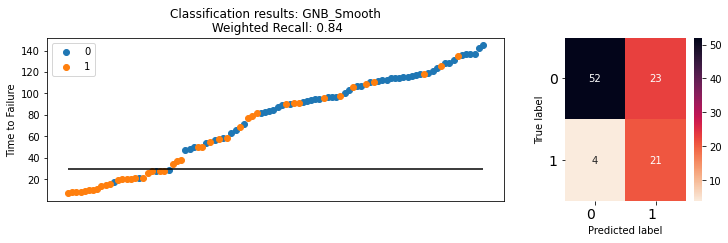

No improvement observed. Current leading model at 0.8033333333333333:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)), ('gnb', GaussianNB())])
Fitting 5 folds for each of 16 candidates, totalling 80 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)), ('gnb', GaussianNB())])
-----------
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        75
           1       0.89      0.64      0.74        25

    accuracy                           0.89       100
   macro avg       0.89      0.81      0.84       100
weighted avg       0.89      0.89      0.88       100

Area under ROC: 0.8066666666666668
Binary Recall: 0.64
Combined: 0.7233333333333334


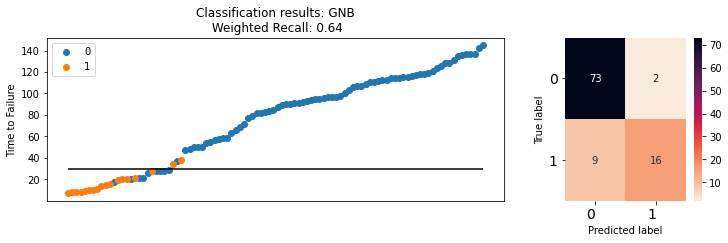

No improvement observed. Current leading model at 0.7233333333333334:
Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=2)), ('gnb', GaussianNB())])


In [10]:
pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('gnb', GaussianNB()),
])

params = {
    'pca__n_components': (3,4,5,6),
    'pfs__degree':(1,2,3,4),
}

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"GNB_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"GNB")

# Quadratic Discriminant Analysis

Fitting 5 folds for each of 16 candidates, totalling 80 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('qda', QuadraticDiscriminantAnalysis())])
-----------
              precision    recall  f1-score   support

           0       0.93      0.75      0.83        75
           1       0.53      0.84      0.65        25

    accuracy                           0.77       100
   macro avg       0.73      0.79      0.74       100
weighted avg       0.83      0.77      0.78       100

Area under ROC: 0.7933333333333332
Binary Recall: 0.84
Combined: 0.8166666666666667


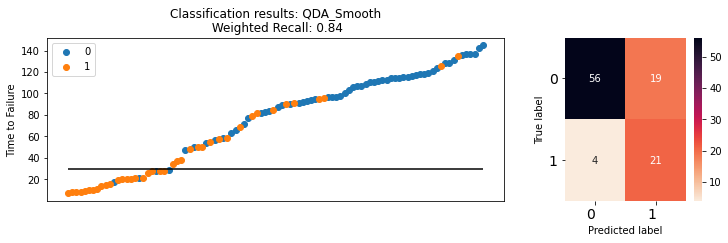

No improvement observed. Current leading model at 0.8166666666666667:
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('qda', QuadraticDiscriminantAnalysis())])
Fitting 5 folds for each of 16 candidates, totalling 80 fits
-----Best Estimator-----
Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=6)),
                ('qda', QuadraticDiscriminantAnalysis())])
-----------
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        75
           1       0.85      0.68      0.76        25

    accuracy                           0.89       100
   macro avg       0.88      0.82      0.84       100
weighted avg       0.89      0.89      0.89       100

Area under ROC: 0.8200000000000001
Binary Recall: 0.68
Combined: 0.75


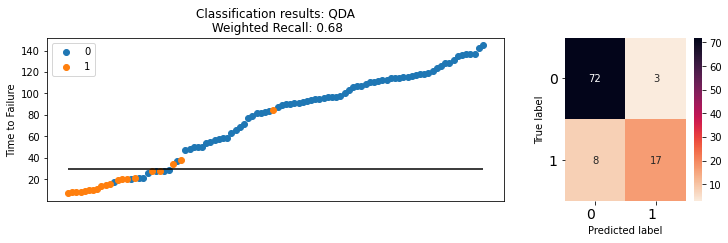

No improvement observed. Current leading model at 0.7733333333333333:
Pipeline(steps=[('ss', StandardScaler()), ('pfs', PolynomialFeatures()),
                ('pca', PCA(n_components=3)),
                ('qda', QuadraticDiscriminantAnalysis())])


In [11]:
pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('qda', QuadraticDiscriminantAnalysis()),
])

params = {
    'pca__n_components': (3,4,5,6),
    'pfs__degree':(1,2,3,4),
}

X_train, y_train = data_split(smooth=True)
fit_validate(pipeline,params,"QDA_Smooth")
                 
X_train, y_train = data_split(smooth=False)
fit_validate(pipeline,params,"QDA")

# Voter

SVM_Smooth
KNN_Smooth
Fitting 5 folds for each of 1 candidates, totalling 5 fits
-----Best Estimator-----
VotingClassifier(estimators=[('SVM_Smooth',
                              Pipeline(steps=[('pfs',
                                               PolynomialFeatures(degree=4)),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=4)),
                                              ('svc',
                                               SVC(C=0.6,
                                                   class_weight='balanced'))])),
                             ('KNN_Smooth',
                              Pipeline(steps=[('pfs',
                                               PolynomialFeatures(degree=1)),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=3)),
                                              ('knn',

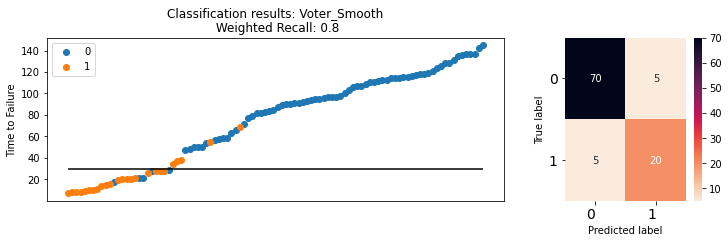

No improvement observed. Current leading model at 0.89:
VotingClassifier(estimators=[('SVM_Smooth',
                              Pipeline(steps=[('pfs',
                                               PolynomialFeatures(degree=4)),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=4)),
                                              ('svc',
                                               SVC(C=0.6,
                                                   class_weight='balanced'))])),
                             ('KNN_Smooth',
                              Pipeline(steps=[('pfs',
                                               PolynomialFeatures(degree=1)),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=3)),
                                              ('knn',
                                               KN

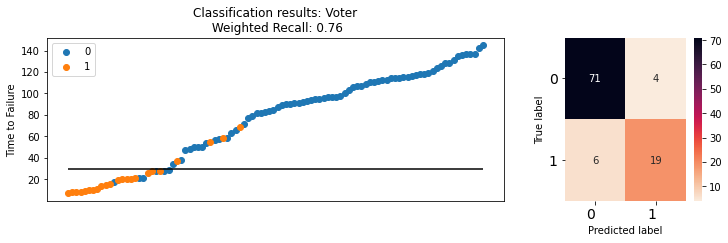

No improvement observed. Current leading model at 0.8300000000000001:
VotingClassifier(estimators=[('NuSVM',
                              Pipeline(steps=[('pfs', PolynomialFeatures()),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=3)),
                                              ('nsvc',
                                               NuSVC(class_weight='balanced',
                                                     nu=0.1))])),
                             ('SVM',
                              Pipeline(steps=[('pfs', PolynomialFeatures()),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=3)),
                                              ('svc',
                                               SVC(C=0.7,
                                                   class_weight='balanced'))])),
            

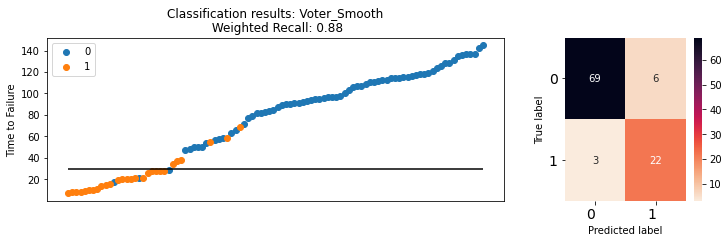

No improvement observed. Current leading model at 0.89:
VotingClassifier(estimators=[('SVM_Smooth',
                              Pipeline(steps=[('pfs',
                                               PolynomialFeatures(degree=4)),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=4)),
                                              ('svc',
                                               SVC(C=0.6,
                                                   class_weight='balanced'))])),
                             ('KNN_Smooth',
                              Pipeline(steps=[('pfs',
                                               PolynomialFeatures(degree=1)),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=3)),
                                              ('knn',
                                               KN

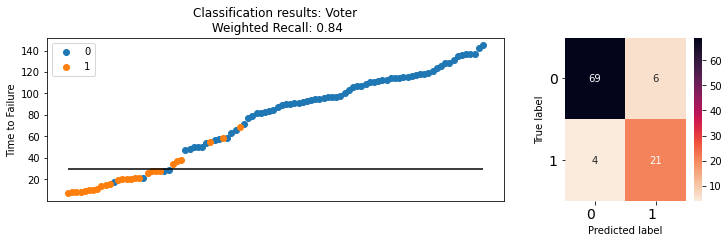

New best score - model saved.
SVM_Smooth
KNN_Smooth
Ada_Smooth
NuSVM_Smooth
Fitting 5 folds for each of 1 candidates, totalling 5 fits
-----Best Estimator-----
VotingClassifier(estimators=[('SVM_Smooth',
                              Pipeline(steps=[('pfs',
                                               PolynomialFeatures(degree=4)),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=4)),
                                              ('svc',
                                               SVC(C=0.6,
                                                   class_weight='balanced'))])),
                             ('KNN_Smooth',
                              Pipeline(steps=[('pfs',
                                               PolynomialFeatures(degree=1)),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=3)),

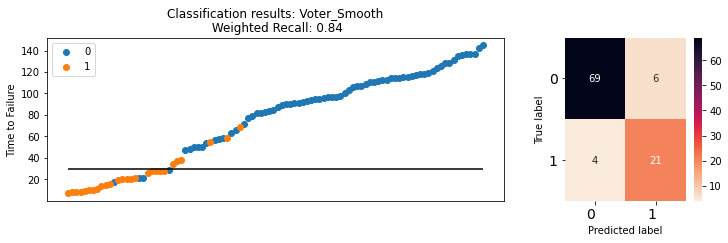

No improvement observed. Current leading model at 0.89:
VotingClassifier(estimators=[('SVM_Smooth',
                              Pipeline(steps=[('pfs',
                                               PolynomialFeatures(degree=4)),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=4)),
                                              ('svc',
                                               SVC(C=0.6,
                                                   class_weight='balanced'))])),
                             ('KNN_Smooth',
                              Pipeline(steps=[('pfs',
                                               PolynomialFeatures(degree=1)),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=3)),
                                              ('knn',
                                               KN

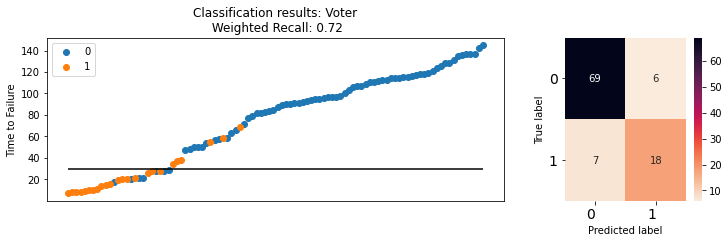

No improvement observed. Current leading model at 0.8599999999999999:
VotingClassifier(estimators=[('NuSVM',
                              Pipeline(steps=[('pfs', PolynomialFeatures()),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=3)),
                                              ('nsvc',
                                               NuSVC(class_weight='balanced',
                                                     nu=0.1))])),
                             ('SVM',
                              Pipeline(steps=[('pfs', PolynomialFeatures()),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=3)),
                                              ('svc',
                                               SVC(C=0.7,
                                                   class_weight='balanced'))])),
            

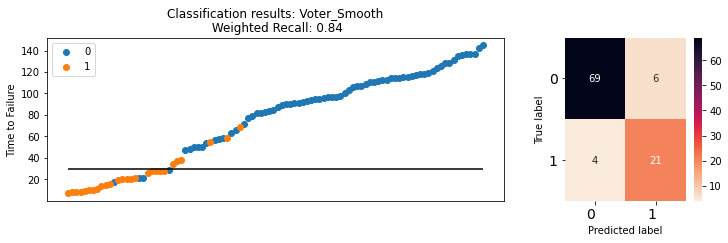

No improvement observed. Current leading model at 0.89:
VotingClassifier(estimators=[('SVM_Smooth',
                              Pipeline(steps=[('pfs',
                                               PolynomialFeatures(degree=4)),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=4)),
                                              ('svc',
                                               SVC(C=0.6,
                                                   class_weight='balanced'))])),
                             ('KNN_Smooth',
                              Pipeline(steps=[('pfs',
                                               PolynomialFeatures(degree=1)),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=3)),
                                              ('knn',
                                               KN

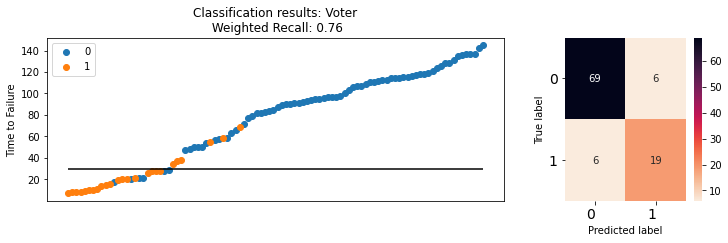

No improvement observed. Current leading model at 0.8599999999999999:
VotingClassifier(estimators=[('NuSVM',
                              Pipeline(steps=[('pfs', PolynomialFeatures()),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=3)),
                                              ('nsvc',
                                               NuSVC(class_weight='balanced',
                                                     nu=0.1))])),
                             ('SVM',
                              Pipeline(steps=[('pfs', PolynomialFeatures()),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=3)),
                                              ('svc',
                                               SVC(C=0.7,
                                                   class_weight='balanced'))])),
            

In [107]:
jar = [file.split(".")[0] for file in os.listdir(r"classifiers/") if file.split(".")[1] == 'pkl']
smoothjar = [file for file in jar if "mooth" in file]
roughjar = [file for file in jar if "mooth" not in file]

for n in range(2,6):
    estimators = assemble_estimators(smoothjar,n)
    X_train, y_train = data_split(smooth=True)
    model = VotingClassifier(estimators, n_jobs=-1)
    fit_validate(model,{},"Voter_Smooth")

    estimators = assemble_estimators(roughjar,n)
    X_train, y_train = data_split(smooth=False)
    model = VotingClassifier(estimators, n_jobs=-1).fit(X_train,y_train)
    fit_validate(model,{},"Voter")

# Stacker

SVM_Smooth
KNN_Smooth
Fitting 5 folds for each of 1 candidates, totalling 5 fits
-----Best Estimator-----
StackingClassifier(estimators=[('SVM_Smooth',
                                Pipeline(steps=[('pfs',
                                                 PolynomialFeatures(degree=4)),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=4)),
                                                ('svc',
                                                 SVC(C=0.6,
                                                     class_weight='balanced'))])),
                               ('KNN_Smooth',
                                Pipeline(steps=[('pfs',
                                                 PolynomialFeatures(degree=1)),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                           

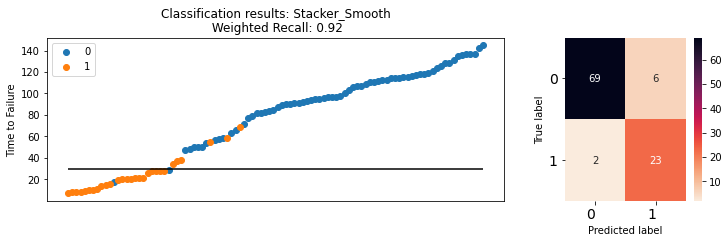

No improvement observed. Current leading model at 0.9199999999999999:
StackingClassifier(estimators=[('KNN_Smooth',
                                Pipeline(steps=[('pfs',
                                                 PolynomialFeatures(degree=1)),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=1))])),
                               ('SVM_Smooth',
                                Pipeline(steps=[('pfs',
                                                 PolynomialFeatures(degree=4)),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=4)),
                                                ('svc',
                                                 SVC(C=0.6,


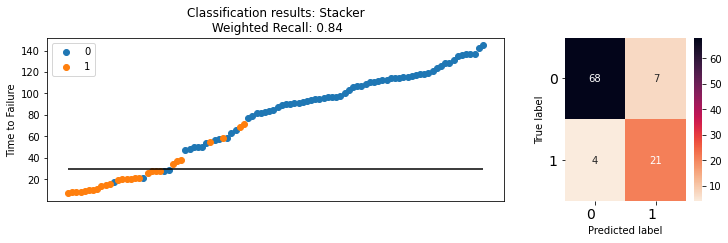

No improvement observed. Current leading model at 0.8599999999999999:
StackingClassifier(estimators=[('NuSVM',
                                Pipeline(steps=[('pfs', PolynomialFeatures()),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                                                ('nsvc',
                                                 NuSVC(class_weight='balanced',
                                                       nu=0.1))])),
                               ('SVM',
                                Pipeline(steps=[('pfs', PolynomialFeatures()),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                                                ('svc',
                                                 SVC(C=0.7,
                                                     class_weight='

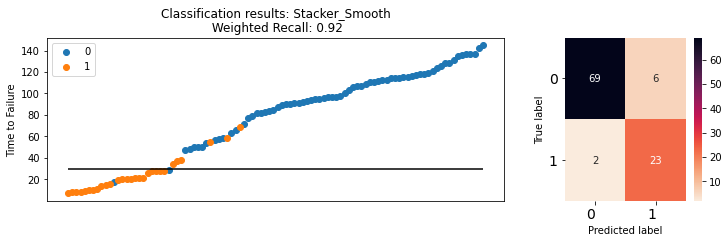

No improvement observed. Current leading model at 0.9199999999999999:
StackingClassifier(estimators=[('KNN_Smooth',
                                Pipeline(steps=[('pfs',
                                                 PolynomialFeatures(degree=1)),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=1))])),
                               ('SVM_Smooth',
                                Pipeline(steps=[('pfs',
                                                 PolynomialFeatures(degree=4)),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=4)),
                                                ('svc',
                                                 SVC(C=0.6,


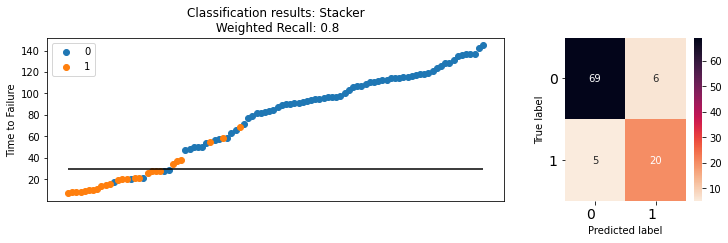

No improvement observed. Current leading model at 0.8599999999999999:
StackingClassifier(estimators=[('NuSVM',
                                Pipeline(steps=[('pfs', PolynomialFeatures()),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                                                ('nsvc',
                                                 NuSVC(class_weight='balanced',
                                                       nu=0.1))])),
                               ('SVM',
                                Pipeline(steps=[('pfs', PolynomialFeatures()),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                                                ('svc',
                                                 SVC(C=0.7,
                                                     class_weight='

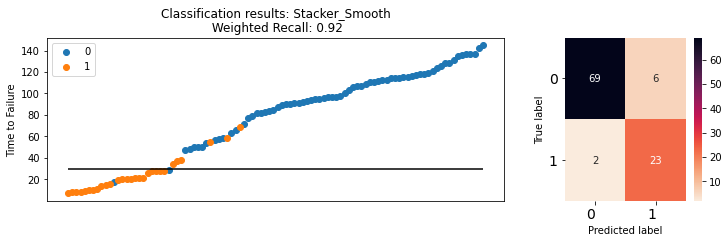

No improvement observed. Current leading model at 0.9199999999999999:
StackingClassifier(estimators=[('KNN_Smooth',
                                Pipeline(steps=[('pfs',
                                                 PolynomialFeatures(degree=1)),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=1))])),
                               ('SVM_Smooth',
                                Pipeline(steps=[('pfs',
                                                 PolynomialFeatures(degree=4)),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=4)),
                                                ('svc',
                                                 SVC(C=0.6,


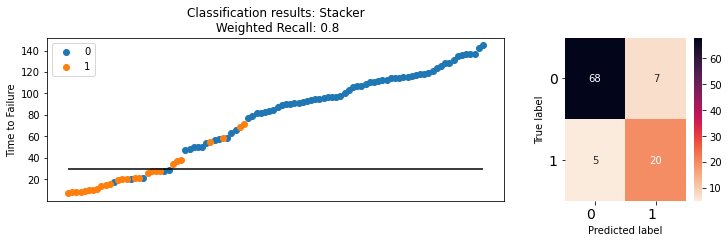

No improvement observed. Current leading model at 0.8599999999999999:
StackingClassifier(estimators=[('NuSVM',
                                Pipeline(steps=[('pfs', PolynomialFeatures()),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                                                ('nsvc',
                                                 NuSVC(class_weight='balanced',
                                                       nu=0.1))])),
                               ('SVM',
                                Pipeline(steps=[('pfs', PolynomialFeatures()),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                                                ('svc',
                                                 SVC(C=0.7,
                                                     class_weight='

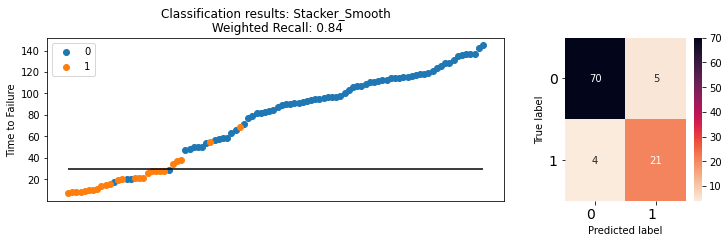

No improvement observed. Current leading model at 0.9199999999999999:
StackingClassifier(estimators=[('KNN_Smooth',
                                Pipeline(steps=[('pfs',
                                                 PolynomialFeatures(degree=1)),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=1))])),
                               ('SVM_Smooth',
                                Pipeline(steps=[('pfs',
                                                 PolynomialFeatures(degree=4)),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=4)),
                                                ('svc',
                                                 SVC(C=0.6,


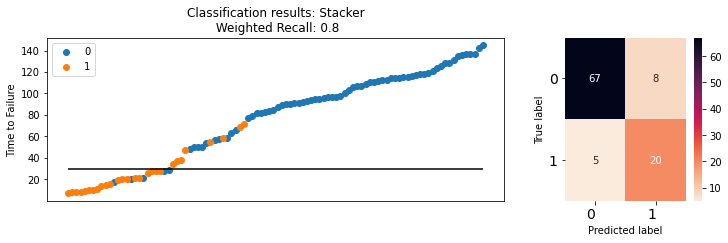

No improvement observed. Current leading model at 0.8599999999999999:
StackingClassifier(estimators=[('NuSVM',
                                Pipeline(steps=[('pfs', PolynomialFeatures()),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                                                ('nsvc',
                                                 NuSVC(class_weight='balanced',
                                                       nu=0.1))])),
                               ('SVM',
                                Pipeline(steps=[('pfs', PolynomialFeatures()),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                                                ('svc',
                                                 SVC(C=0.7,
                                                     class_weight='

In [108]:
jar = [file.split(".")[0] for file in os.listdir(r"classifiers/") if file.split(".")[1] == 'pkl']
smoothjar = [file for file in jar if "Smooth" in file or "smooth" in file]
roughjar = [file for file in jar if "Smooth" not in file and "smooth" not in file]

params = {
        'final_estimator':(
                            QuadraticDiscriminantAnalysis(),
                            #svm.NuSVC(nu=0.25),
                            #LinearDiscriminantAnalysis(),
                            #RandomForestClassifier(),
                            #DecisionTreeClassifier(),
                            #KNeighborsClassifier(),
                            )}
for i in range(2,6):
    estimators = assemble_estimators(smoothjar,i)
    model=StackingClassifier(estimators)
    X_train, y_train = data_split(smooth=True)
    fit_validate(model,params,"Stacker_Smooth")

    estimators = assemble_estimators(roughjar,i)
    model=StackingClassifier(estimators)
    X_train, y_train = data_split(smooth=False)
    fit_validate(model,params,"Stacker")



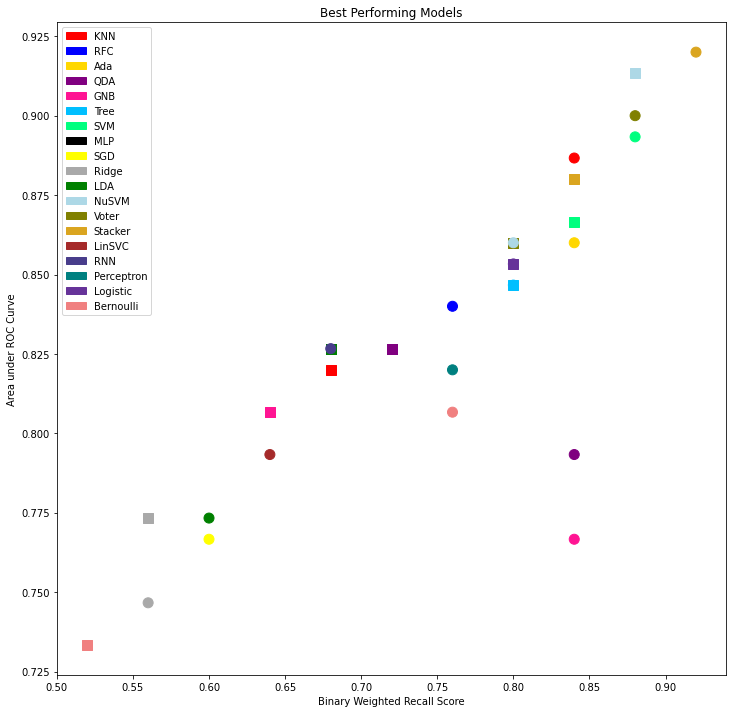

In [103]:
import os
import matplotlib.patches as mpatch

jar = [file.split(".")[0] for file in os.listdir(r"classifiers/") if file.split(".")[1] == 'pkl']
smoothjar = [file for file in jar if "Smooth" in file or "smooth" in file]
roughjar = [file for file in jar if "Smooth" not in file and "smooth" not in file]

X_val = pd.read_csv("test_selected.csv")
X_val.pop("id")
y_val = [int(int(line)<=30) for line in open("PM_truth.txt", "r").readlines()]

colors={
        'KNN':'red',
       'RFC':'blue',
       'Ada':'gold',
       'QDA':'purple',
       'GNB':'deeppink',
       'Tree':'deepskyblue',
       'SVM':'springgreen',
        'MLP':'black',
        'SGD':'yellow',
        'Ridge':'darkgray',
        'LDA':'green',
        'NuSVM':'lightblue',
        'Voter':'olive',
        'Stacker':'goldenrod',
        'LinSVC':'brown',
        'RNN':'darkslateblue',
        'Perceptron':'teal',
        'Logistic':'rebeccapurple',
        'Bernoulli':'lightcoral',
       }

handles = list()
for key in colors.keys():
    handles.append(mpatch.Patch(color=colors[key],label=key))

rmodels,rx,ry,rcolor,rshape = list(), list(), list(), list(), list()
for name in roughjar:
    file = open(r"classifiers/{}.pkl".format(name),'rb')
    model = pickle.load(file)
    file.close()
    rmodels.append(name)
    rcolor.append(colors[name])
    rx.append(metrics.recall_score(y_val,model.predict(X_val),average='binary'))
    ry.append(metrics.roc_auc_score(y_val,model.predict(X_val)))

smodels,sx,sy,scolor,sshape = list(), list(), list(), list(), list()
for name in smoothjar:
    file = open(r"classifiers/{}.pkl".format(name),'rb')
    model = pickle.load(file)
    file.close()
    scolor.append(colors[name.split("_")[0]])
    smodels.append(name.split("_")[0])
    sx.append(metrics.recall_score(y_val,model.predict(X_val),average='binary'))
    sy.append(metrics.roc_auc_score(y_val,model.predict(X_val)))

plt.figure(figsize=(12,12))
plt.scatter(x=rx,y=ry,s=100,marker="s",c=rcolor)
plt.scatter(x=sx,y=sy,s=100,marker="o",c=scolor)
plt.xlabel("Binary Weighted Recall Score")
plt.ylabel("Area under ROC Curve")
plt.title("Best Performing Models")
plt.legend(
            handles=handles,
           #loc='lower left'
          )
plt.show()


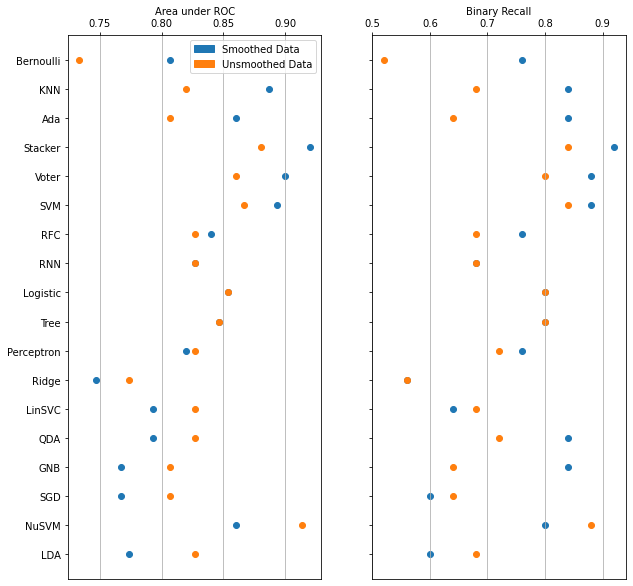

In [12]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


jar = [file.split(".")[0] for file in os.listdir(r"classifiers/") if file.split(".")[1] == 'pkl']
roughjar = [file for file in jar if "mooth" not in file]

r_auc,r_recall,s_auc,s_recall,names, auc_diff, recall_diff = list(), list(), list(), list(),list(),list(),list()
for name in roughjar:
    file = open(r"classifiers/{}.pkl".format(name),'rb')
    model = pickle.load(file)
    file.close()
    r_pred = model.predict(X_val)
    r_a = metrics.roc_auc_score(y_val,r_pred)
    r_r = metrics.recall_score(y_val,r_pred,average="binary")
    file = open(r"classifiers/{}_Smooth.pkl".format(name),'rb')
    model = pickle.load(file)
    file.close()
    s_pred = model.predict(X_val)
    s_a = metrics.roc_auc_score(y_val,s_pred)
    s_r = metrics.recall_score(y_val,s_pred,average="binary")
    auc_diff.append(r_a-s_a)
    recall_diff.append(r_r-s_r)
    names.append(name)
    r_auc.append(r_a)
    s_auc.append(s_a)
    r_recall.append(r_r)
    s_recall.append(s_r)

df = pd.DataFrame(zip(names,r_auc,r_recall,s_auc,s_recall,auc_diff,recall_diff),
                 columns=("Model","Rough AUC","Rough Recall","Smooth AUC","Smooth Recall","AUC Diff","Recall Diff"))

handles = list()
colors={"Smoothed Data":"tab:blue",
        "Unsmoothed Data":"tab:orange"}
for key in colors.keys():
    handles.append(mpatch.Patch(color=colors[key],
                                label=key))
f, (ax1,ax2) = plt.subplots(ncols=2,sharey=True,figsize=(10,10))
df.sort_values(by="AUC Diff", inplace=True, ascending=False)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
#ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.grid(axis='x',which='major',)
ax1.grid(axis='x',which='minor',linestyle=":")
ax1.set_xlabel("Area under ROC")
ax1.legend(handles=handles)
scatter = ax1.scatter(df["Smooth AUC"],
                     df["Model"],
                     c="tab:blue")
scatter = ax1.scatter(df["Rough AUC"],
                     df["Model"],
                     c="tab:orange")
                  
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.grid(axis='x',which='major',)
ax2.grid(axis='x',which='minor',linestyle=":")
ax2.set_xlabel("Binary Recall")
scatter = ax2.scatter(df["Smooth Recall"],
                     df["Model"],
                     c="tab:blue")
scatter = ax2.scatter(df["Rough Recall"],
                     df["Model"],
                     c="tab:orange")

plt.show()

Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=6)),
                ('log', LogisticRegression(class_weight='balanced'))])


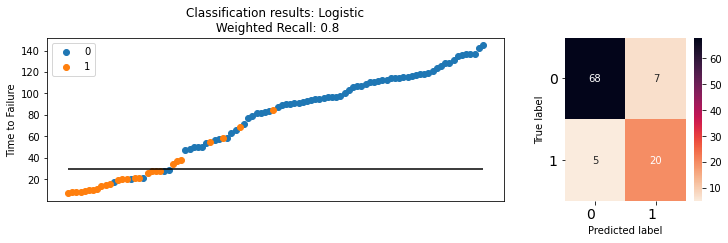

Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('rnn',
                 RadiusNeighborsClassifier(radius=2, weights='distance'))])


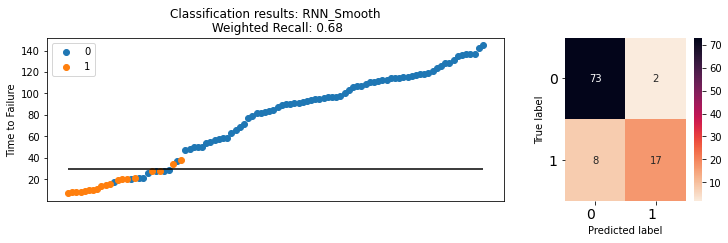

Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)),
                ('etc', ExtraTreesClassifier(max_depth=15))])


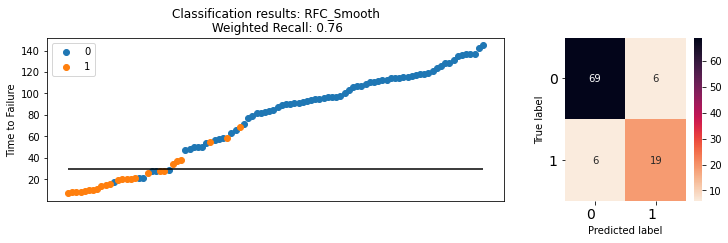

StackingClassifier(estimators=[('KNN_Smooth',
                                Pipeline(steps=[('pfs',
                                                 PolynomialFeatures(degree=1)),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=1))])),
                               ('SVM_Smooth',
                                Pipeline(steps=[('pfs',
                                                 PolynomialFeatures(degree=4)),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=4)),
                                                ('svc',
                                                 SVC(C=0.6,
                                                     class_weight='bal

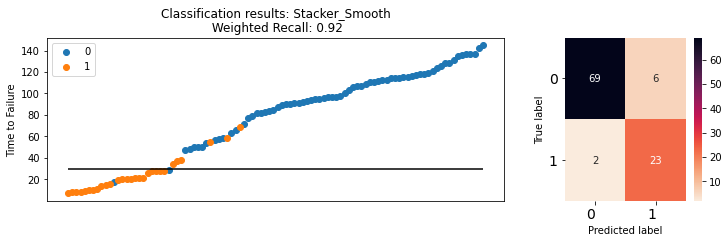

Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('nsvc', NuSVC(class_weight='balanced', nu=0.05))])


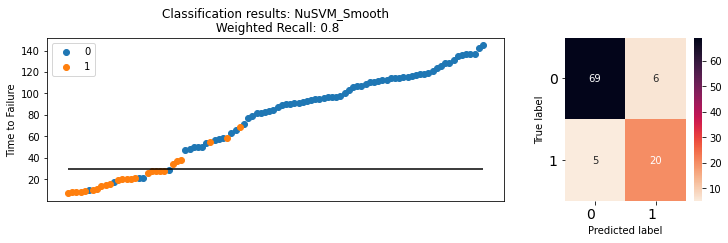

Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('log', LogisticRegression(class_weight='balanced'))])


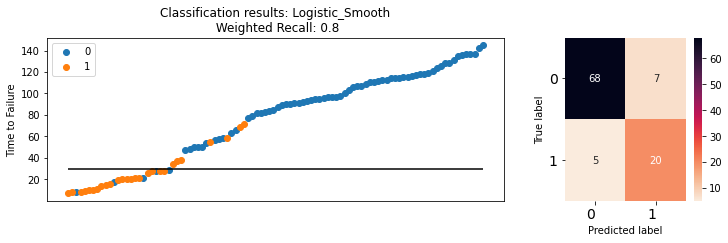

Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=2)), ('lsv', LinearSVC())])


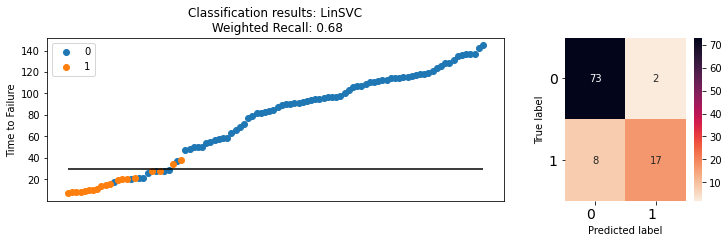

Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('qda', QuadraticDiscriminantAnalysis())])


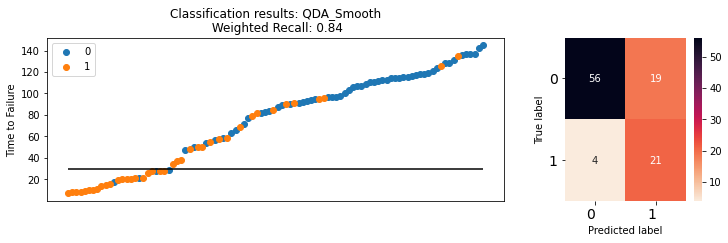

Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('svc', SVC(C=0.7, class_weight='balanced'))])


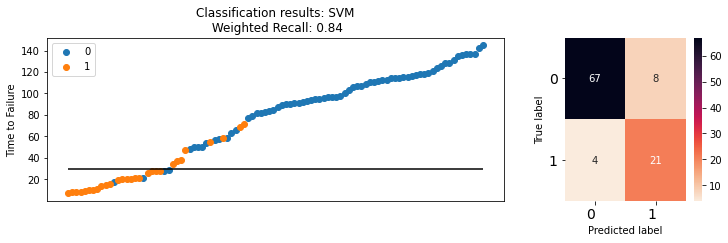

Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('nsvc', NuSVC(class_weight='balanced', nu=0.1))])


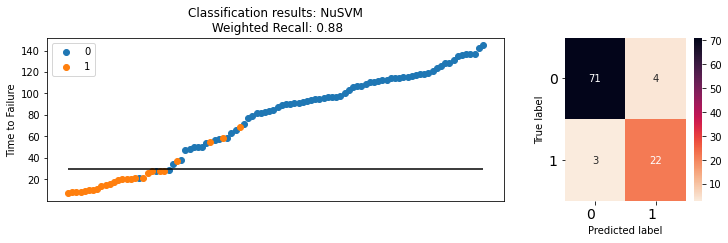

Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('rnn',
                 RadiusNeighborsClassifier(radius=1.5, weights='distance'))])


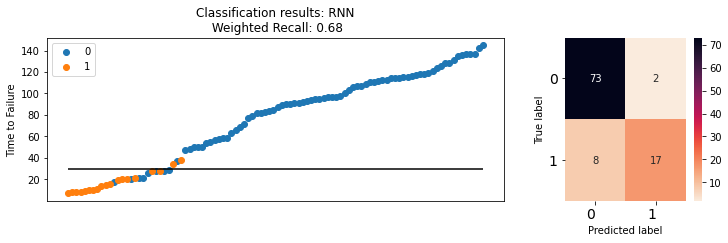

Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)),
                ('rfc', RandomForestClassifier(max_depth=5, n_estimators=200))])


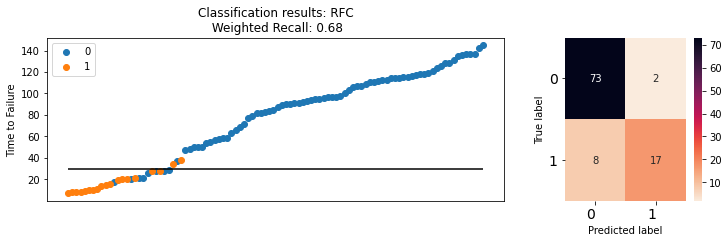

Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=6)), ('per', Perceptron())])


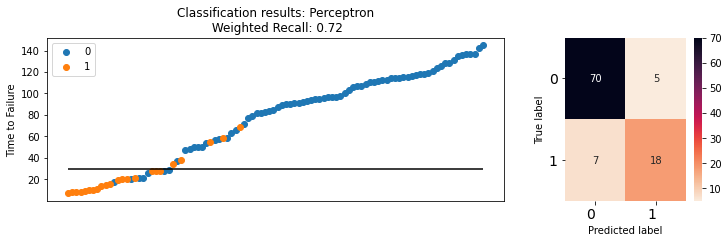

Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=2)), ('ada', AdaBoostClassifier())])


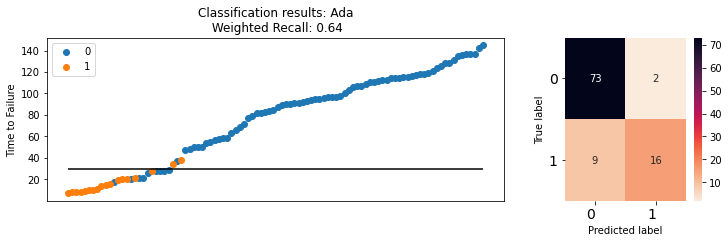

Pipeline(steps=[('ss', StandardScaler()), ('pfs', PolynomialFeatures()),
                ('pca', PCA(n_components=3)),
                ('qda', QuadraticDiscriminantAnalysis())])


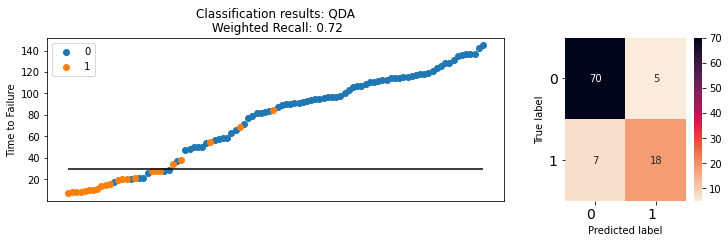

VotingClassifier(estimators=[('SVM_Smooth',
                              Pipeline(steps=[('pfs',
                                               PolynomialFeatures(degree=4)),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=4)),
                                              ('svc',
                                               SVC(C=0.6,
                                                   class_weight='balanced'))])),
                             ('KNN_Smooth',
                              Pipeline(steps=[('pfs',
                                               PolynomialFeatures(degree=1)),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=3)),
                                              ('knn',
                                               KNeighborsClassifier(n_neighbors=1))])),
                 

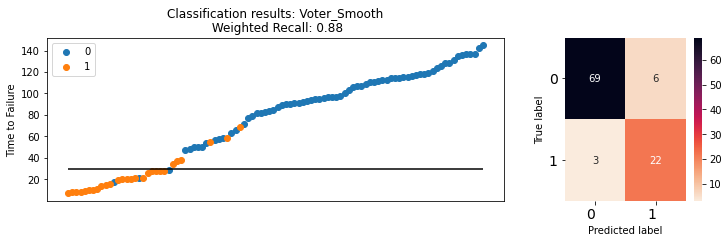

Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('lda', LinearDiscriminantAnalysis())])


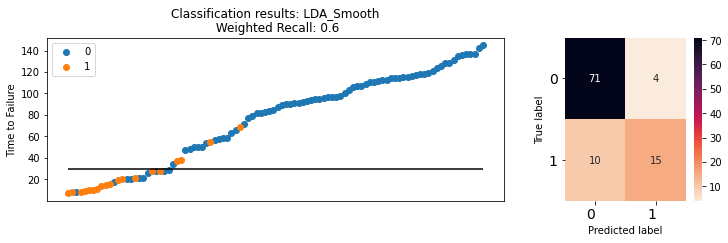

Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)), ('sgd', SGDClassifier())])


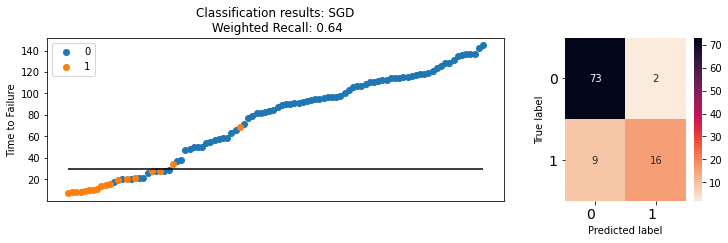

VotingClassifier(estimators=[('NuSVM',
                              Pipeline(steps=[('pfs', PolynomialFeatures()),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=3)),
                                              ('nsvc',
                                               NuSVC(class_weight='balanced',
                                                     nu=0.1))])),
                             ('SVM',
                              Pipeline(steps=[('pfs', PolynomialFeatures()),
                                              ('ss', StandardScaler()),
                                              ('pca', PCA(n_components=3)),
                                              ('svc',
                                               SVC(C=0.7,
                                                   class_weight='balanced'))])),
                             ('Logistic',
                              Pipeline(s

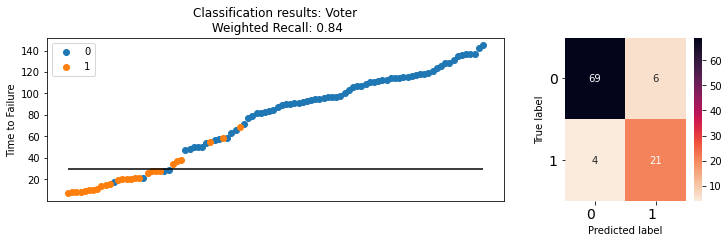

Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)), ('gnb', GaussianNB())])


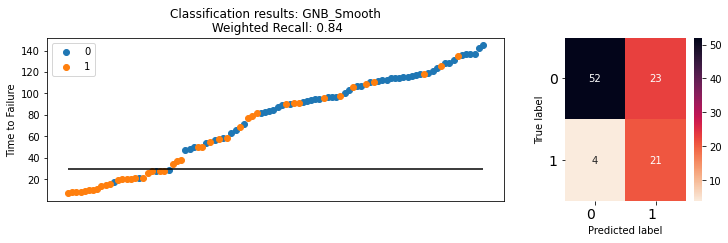

Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)), ('ada', AdaBoostClassifier())])


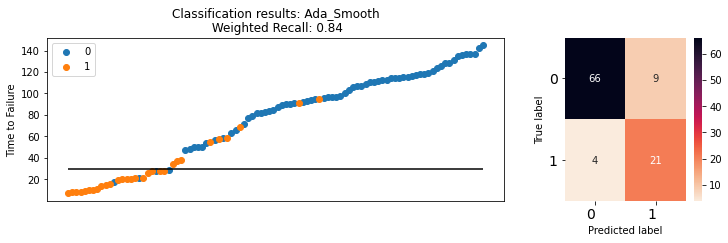

Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)), ('per', Perceptron())])


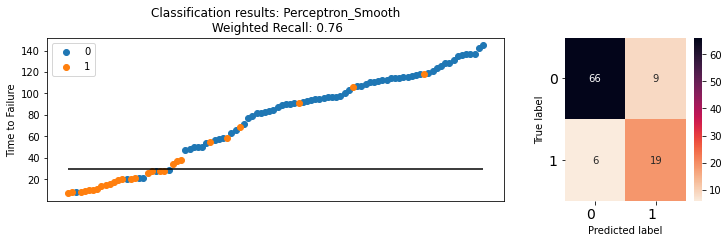

Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('rdg', RidgeClassifier(solver='sag'))])


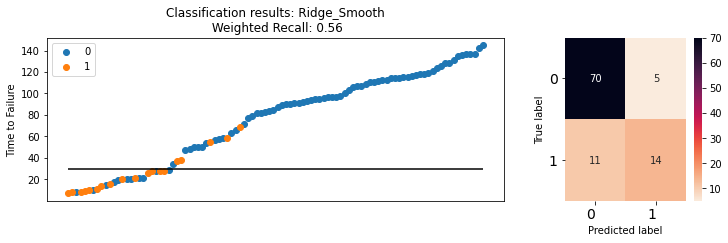

Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('svc', SVC(C=0.6, class_weight='balanced'))])


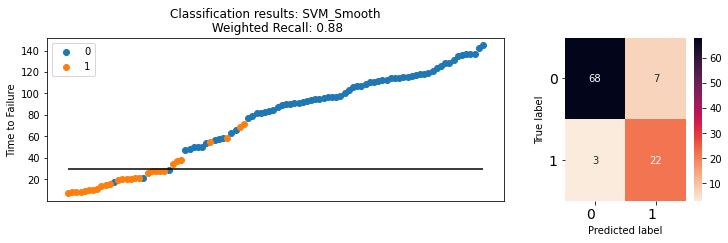

Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=5)), ('rdg', RidgeClassifier())])


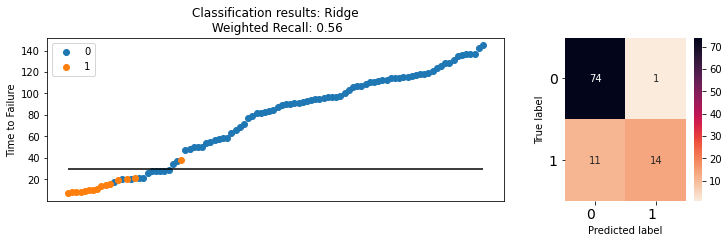

Pipeline(steps=[('pfs', PolynomialFeatures()),
                ('tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=1,
                                        max_features='log2',
                                        min_samples_leaf=9))])


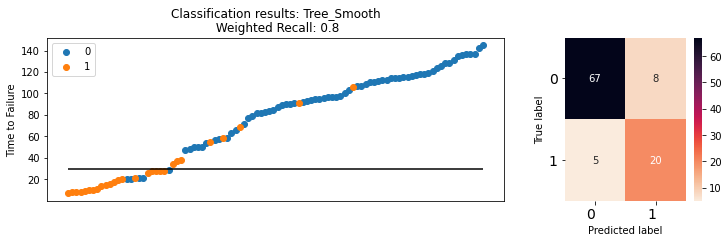

Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=2)), ('gnb', GaussianNB())])


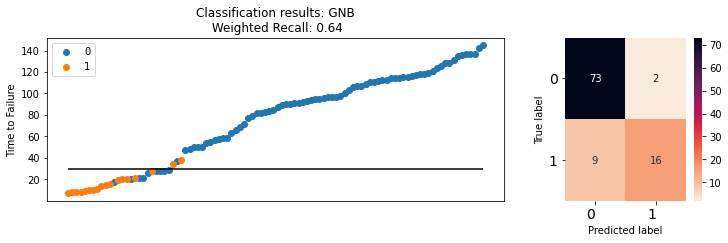

Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)), ('lsv', LinearSVC())])


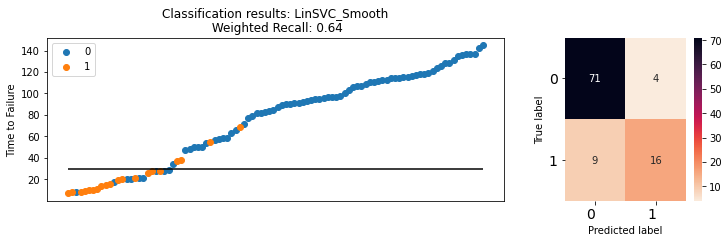

Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=5)), ('bnb', BernoulliNB())])


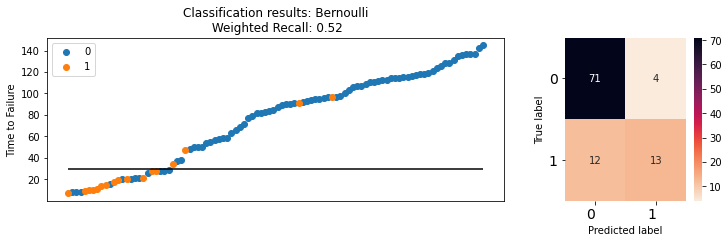

StackingClassifier(estimators=[('NuSVM',
                                Pipeline(steps=[('pfs', PolynomialFeatures()),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                                                ('nsvc',
                                                 NuSVC(class_weight='balanced',
                                                       nu=0.1))])),
                               ('SVM',
                                Pipeline(steps=[('pfs', PolynomialFeatures()),
                                                ('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3)),
                                                ('svc',
                                                 SVC(C=0.7,
                                                     class_weight='balanced'))])),
                               ('Tree',
              

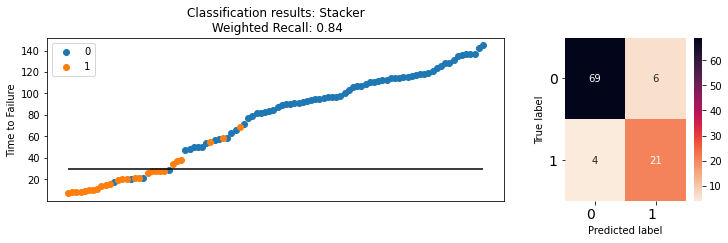

Pipeline(steps=[('pfs', PolynomialFeatures(degree=3)),
                ('tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=1,
                                        max_features='log2',
                                        min_samples_leaf=13))])


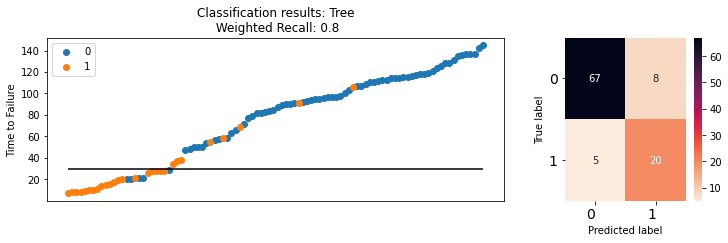

Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('knn', KNeighborsClassifier(n_neighbors=1))])


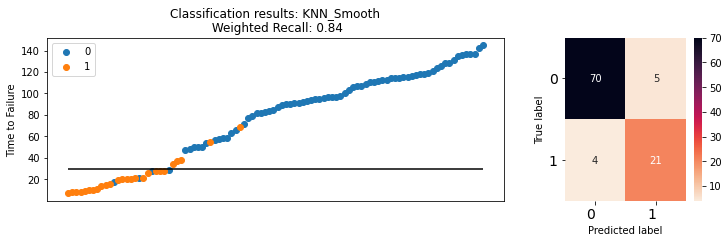

Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)), ('bnb', BernoulliNB())])


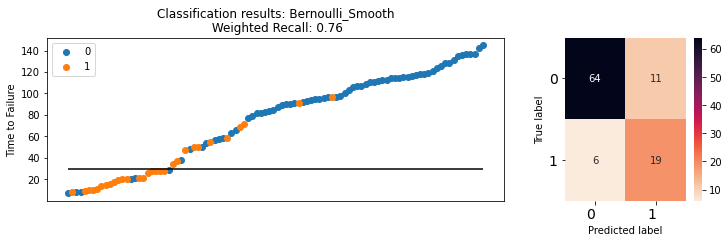

Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('lda', LinearDiscriminantAnalysis())])


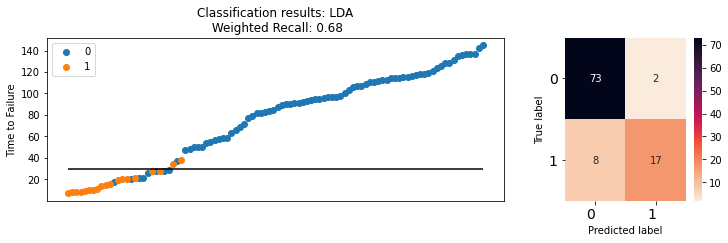

Pipeline(steps=[('pfs', PolynomialFeatures()), ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('knn', KNeighborsClassifier(n_neighbors=10))])


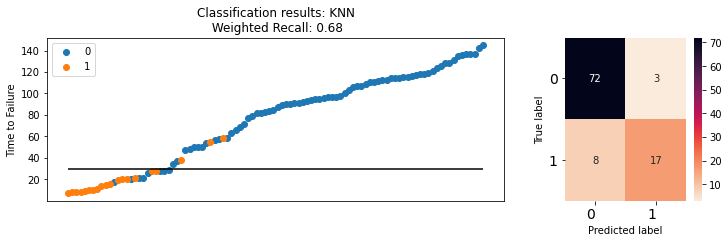

Pipeline(steps=[('pfs', PolynomialFeatures(degree=1)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('sgd', SGDClassifier(loss='modified_huber'))])


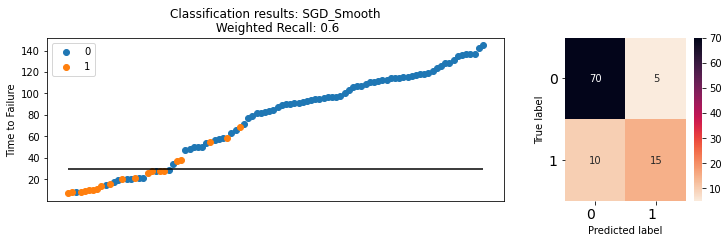

In [109]:
jar = [file.split(".")[0] for file in os.listdir(r"classifiers/") if file.split(".")[1] == 'pkl']

for name in jar:
    file = open(r"classifiers/{}.pkl".format(name),'rb')
    model = pickle.load(file)
    file.close()
    print(model)
    resultplot(model,name)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


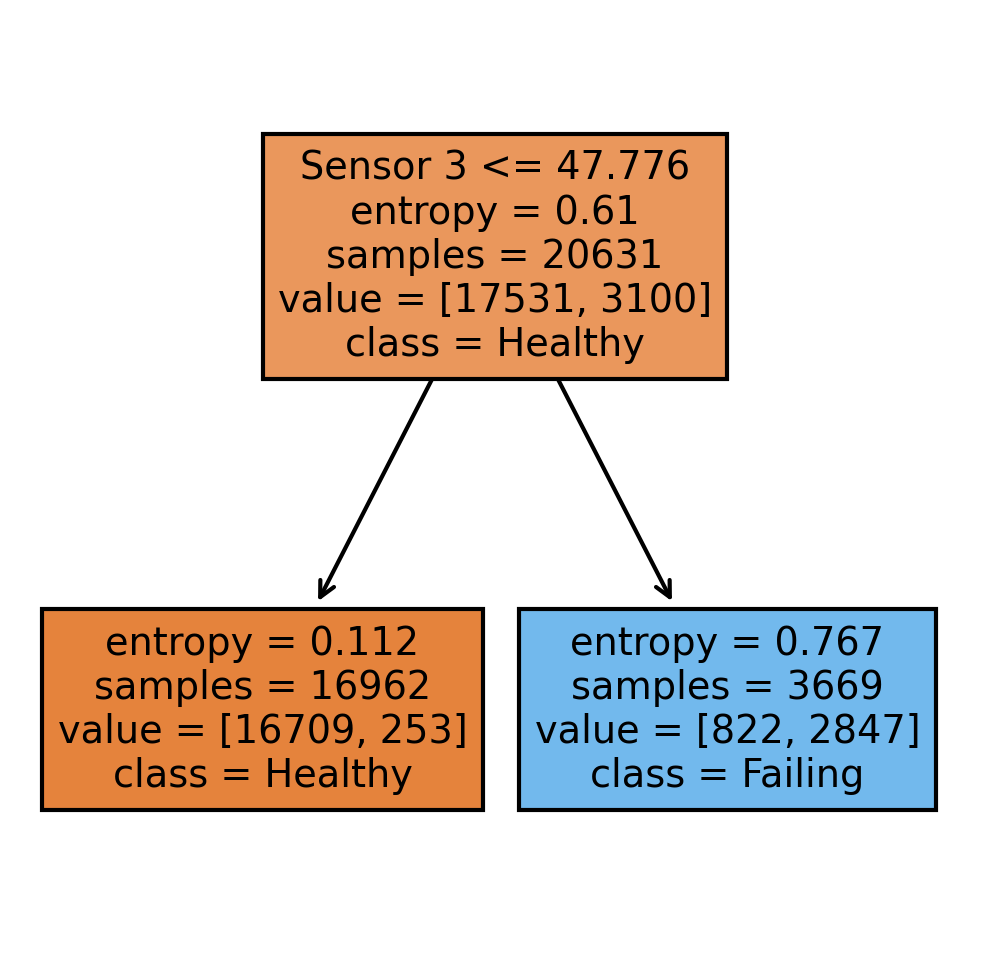

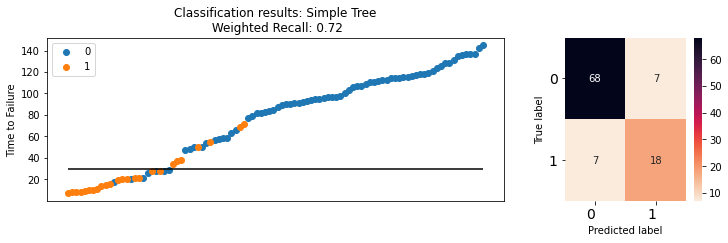

In [30]:
X_train,y_train = data_split(smooth=True)

clf = DecisionTreeClassifier()
params = ({
    'max_depth':(range(1,15,1)),
    'criterion':('gini','entropy'),
    'max_features':('sqrt','log2'),
    'min_samples_leaf':(1,15,1)
        })
gs = GridSearchCV(clf,params,
                  verbose=10,n_jobs=-1,
                 scoring=rocall).fit(X_train,y_train)

fn=["Cycle","Sensor 1","Sensor 2","Sensor 3", "Sensor 4"]
cn=["Healthy","Failing"]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(gs.best_estimator_,
               feature_names = fn, 
               class_names=cn,
               filled = True);
plt.show()

resultplot(gs.best_estimator_,"Simple Tree")

In [19]:
jar = [file.split(".")[0] for file in os.listdir(r"classifiers/") if file.split(".")[1] == 'pkl']
names, models, recall, auc, smoothed = list(), list(), list(), list(), list()
for name in jar:
    file = open(r"classifiers/{}.pkl".format(name),'rb')
    model = pickle.load(file)
    file.close()
    names.append(name)
    models.append(model)
    pred_val = model.predict(X_val)
    recall.append(metrics.recall_score(y_val,pred_val,average='binary'))
    auc.append(metrics.roc_auc_score(y_val,pred_val))
    smoothed.append(len(name.split("_"))>1)
results = pd.DataFrame(zip(names,models,recall,auc,smoothed),
                       columns=("Name","Pipeline","Binary Recall","Area under ROC","Smoothed")
                      ).sort_values(by="Area under ROC").reset_index()
results.to_excel("Classifier_Results.xlsx")
print("Done")

Done


10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100


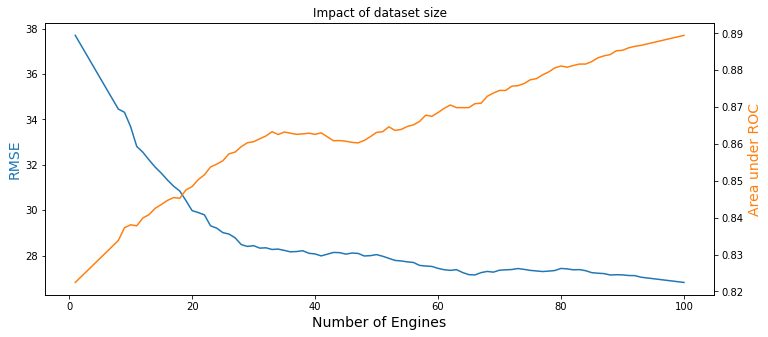

In [8]:
import random
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

def randomengines(n,label):
    engines = set(range(1,101))
    partial = data.loc[data['id'].isin(random.sample(engines, k=n))]
    y_train = partial.pop(label)
    return partial[["cycle","sm_s1","sm_s2","sm_s3","sm_s4"]], y_train

X_val = pd.read_csv("test_selected.csv")
X_val.pop("id")
y_val = [int(line) for line in open("PM_truth.txt", "r").readlines()]
data = pd.read_csv("train_selected.csv")
sm_s1, sm_s2, sm_s3, sm_s4 = list(),list(),list(),list()
for engine, group in data.groupby("id"):
    sm_s1.extend(savgol_filter(group["s1"],25,1))
    sm_s2.extend(savgol_filter(group["s2"],25,1))
    sm_s3.extend(savgol_filter(group["s3"],25,1))
    sm_s4.extend(savgol_filter(group["s4"],25,1))
data["sm_s1"] = sm_s1
data["sm_s2"] = sm_s2
data["sm_s3"] = sm_s3
data["sm_s4"] = sm_s4


pipeline = Pipeline([
                ('pfs', PolynomialFeatures(degree=3)),
                ('ss', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('grb', GradientBoostingRegressor(loss='lad',
                                                 random_state=0)),
                    ])

rscores = list()
for i in range(1,101):
    if i % 10 == 0:print(i)
    subscore = list()
    for _ in range(10):
        X_train,y_train = randomengines(i,'ttf')
        pipeline.fit(X_train,y_train)
        pred = pipeline.predict(X_val)
        score = metrics.mean_squared_error(y_val, pred,squared=False)
        subscore.append(score)
    rscores.append(np.average(np.asarray(subscore)))

y_val = [int(int(line)<=30) for line in open("PM_truth.txt", "r").readlines()]

pipeline = Pipeline([
    ('pfs', PolynomialFeatures(degree=1)),
    ('ss', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('knn', KNeighborsClassifier(n_neighbors=1))
        ])

cscores = list()
for i in range(1,101):
    if i % 10 == 0:print(i)
    subscore = list()
    for _ in range(10):
        X_train,y_train = randomengines(i,'label_bnc')
        pipeline.fit(X_train,y_train)
        pred = pipeline.predict(X_val)
        score = metrics.roc_auc_score(y_val, pred)
        subscore.append(score)
    cscores.append(np.average(np.asarray(subscore)))

fig,ax = plt.subplots(figsize=(12,5))
ax.plot(range(1,101),savgol_filter(rscores,15,1), color='tab:blue')
ax.set_xlabel("Number of Engines",fontsize=14)
ax.set_ylabel("RMSE",color="tab:blue",fontsize=14)
ax2=ax.twinx()
ax2.plot(range(1,101),savgol_filter(cscores,15,1), color='tab:orange')
ax2.set_ylabel("Area under ROC",color="tab:orange",fontsize=14)
ax.set_title("Impact of dataset size")
plt.show()

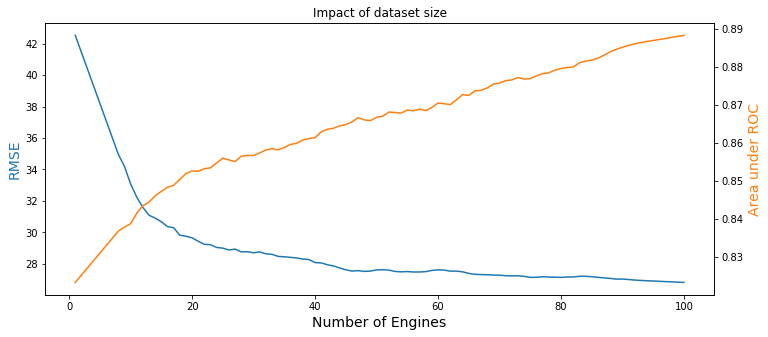

In [102]:
fig,ax = plt.subplots(figsize=(12,5))
ax.plot(range(1,101),savgol_filter(rscores,15,1), color='tab:blue')
ax.set_xlabel("Number of Engines",fontsize=14)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAwAAAAFRCAYAAADDzMr1AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+j8jraAAAgAElEQVR4nOzdd3xV9f3H8dcni4QAl73CCHuIQFBx4AYVBQe2dVu3dqlV+7O0tfVWa6Wte9Rq1bparQtEwS2KA5URQPYMIyCbMMLI+P7++B5KjAEukNxzk7yfj8d9JPecc8/53Dxa+X7O+Xw/X3POISIiIiIitUNS2AGIiIiIiEj8KAEQEREREalFlACIiIiIiNQiSgBERERERGoRJQAiIiIiIrWIEgARERERkVpECYCISDVkZsPMbJmZbTGznBiO/9jMro5HbPFgZjPN7MSw4xARqY6UAIhIjWdmeWY2KOw4yjIzZ2adD+IU9wC/cM7Vc87lVlZcEL+/18Fcxzl3iHPu40oOSUSkVlACICJSPbUHZoYdhIiIVD9KAESkVjGzy83sczO738w2mtkiMzsm2L7MzFab2WVljn/GzP5hZu+b2WYz+8TM2pfZ/2DwuU1mNtnMjiuzL9nMfmtmC4PPTjaztmY2PjhkWlDCc34FcSaZ2W1mtiSI6Tkzi5hZHTPbAiQHn1+4h+95ipnNMbMCM3sEsDL7OpnZR2a2zszWmtm/zaxhsO95oB3wZhDbrcH2V8zs2+B8483skDLnO8PMZgXfMd/MflVm31Azmxr8rb8ws957u06579DUzN4KPrvezD41s6Rg3/+eHgT7twSvrcHTley9XV9EpDZTAiAitdGRwHSgCfAf4CXgCKAzcAnwiJnVK3P8xcCdQFNgKvDvMvsmAn2BxsG5XjGz9GDfzcCFwBlAA+BKoNA5d3ywv09QwvPfCmK8PHidBHQE6gGPOOd2OOfqlfl8p/IfNLOmwGvAbUHMC4EBZQ8B7gZaAz2AtkAUwDl3KbAUODOI7a/BZ94GugDNgSnl/gZPAdc55+oDvYCPgjj6AU8D1+H/1o8Do82szl6uU9YtwHKgGdAC+C3gyh/knGsYnKMe8CDwKZC/t+tXcC0RkVpDCYCI1EaLnXP/cs6VAP/FD4DvCAbX7wE78cnALmOcc+OdczuA3wFHm1lbAOfcC865dc65YufcvUAdoFvwuauB25xzc503zTm3LsYYLwbuc84tcs5tAX4DXGBmKTF89gxglnPuVedcEfAA8O2unc65Bc6594Pvuwa4Dzhhbyd0zj3tnNsc/A2iQB8ziwS7i4CeZtbAObfBOTcl2H4N8Lhz7ivnXIlz7llgB3BUjH+DIqAV0N45V+Sc+9Q5970EYJfgScpFwA+C732w1xcRqZGUAIhIbbSqzO/bAJxz5beVfQKwbNcvwWB8Pf7uOWZ2i5nNDkpjNgIR/F138IlFhSU6MWgNLCnzfgmQgr8THstny8bsyr43s+Zm9lJQrrMJeKFMzN8TlDKNCEqZNgF5wa5dn/kBPulYEpRIHR1sbw/cEpTfbAz+Pm2D+GLxN2AB8F5QqjV8LzHmAI8Aw4KkpjKuLyJSIykBEBHZt7a7fglKgxoDK4J6/18D5wGNnHMNgQJ219svA75XohOjFfgB7C7tgGK+m7zsycpyMVvZ9/jyHwf0ds41wJc9WZn95e+yXwScDQzCJzjZu04N4Jyb6Jw7G18eNAp4Odi/DLgrKNHZ9arrnHtxD9f5juCJwy3OuY7AmcDNZjaw/HFm1gwYie+KVLYj0r6uLyJSKykBEBHZtzPM7FgzS8PPBfjKObcMqI8flK8BUszsD/ha/12eBO40sy7m9TazJsG+Vfja/j15EbjJzDoEScefgf8654pjiHcMcIiZnRuUDN0AtCyzvz6wBdhoZlnA/5X7fPnY6uNLZ9YBdYNYADCzNDO72MwiQdnNJqAk2P1P4CdmdmTw/TPNbIiZ1Y/lbxBM4O0cJDC7zltS7pgU/HyHf1cwl2Jf1xcRqZWUAIiI7Nt/gNvxpT+H4evzAd7FT46dhy/R2U6ZUht8bf3LwHv4AexTQEawLwo8G5SmnFfBNZ8GngfGA4uDc18fS7DOubXAj4AR+EF7F+DzMof8EeiHf1oxBni93CnuBm4LYvsV8Fzw/fKBWcCX5Y6/FMgLyoN+gn+igHNuEr4O/xFgA76c5/K9XKe8LsAH+GRlAvD3Cnr/twGOA35ZphPQFjNrF8P1RURqJdvLfCoRkVrPzJ4Bljvnbgs7FhERkcqgJwAiIiIiIrWIEgARERERkVpEJUAiIiIiIrWIngCIiIiIiNQiSgBERERERGqRWJaUTzhJSUkuIyNj3weKiIiIiBygwsJC55yrcTfMq2UCkJGRwdatW8MOQ0RERERqMDPbFnYMVaHGZTQiIiIiIvFiZoPNbK6ZLTCz4RXsb2dm48ws18ymm9kZwfY0M/uXmX1jZtPM7MR4xawEQERERETkAJhZMvAocDrQE7jQzHqWO+w24GXnXA5wAfD3YPs1AM65Q4FTgHvNLC5jcyUAIiIiIiIHpj+wwDm3yDm3E3gJOLvcMQ5oEPweAVYEv/cEPgRwzq0GNgKHV3nEKAEQERERETlQWcCyMu+XB9vKigKXmNlyYCxwfbB9GnC2maWYWQfgMKBt1YbrKQEQEREREalYiplNKvO6ttx+q+Az5VfZvRB4xjnXBjgDeD4o9XkanzBMAh4AvgCKKzf8ilXLLkAiIiIiInFQ7JzbW1nOcr57174Nu0t8drkKGAzgnJtgZulA06Ds56ZdB5nZF8D8Sol6H/QEQERERETkwEwEuphZBzNLw0/yHV3umKXAQAAz6wGkA2vMrK6ZZQbbT8EnG7PiEbSeAIiIiIiIHADnXLGZ/QJ4F0gGnnbOzTSzO4BJzrnRwC3AP83sJnx50OXOOWdmzYF3zawUyAcujVfc5lz5MqXEl5mZ6bQQmIiIiIhUJTMrdM5lhh1HZVMJUIwWrN7CC18uCTsMERERkdqhpAjWzIWZo2Du22FHU6OoBChGY79ZyX3vz+Ok7s3JapgRdjgiIiIiNUNJEaxfBKtnw5o5/rV6DqxbAKVF/pi2R0K308ONswZRAhCjYTlZ3Pf+PEbl5vPzkzqHHY6IiIhI9bJroL9rgL9m9vcH+hg0ag/NekC3wdCsu3817Rpq6DWNEoAYtW1clyOyGzEyN5+fndgJs4ravoqIiIjUciXFwUA/GODvuqu/dn7FA/2up0HzHrsH+ml1Qw2/NlACsB/OycnidyNnMCN/E4e2iYQdjoiIiEh4Sophw+LdpTurZ/ua/XXzoWTn7uMatvcD/C6n+kF+8+7QtJsG+iFSArAfhh7amj+OnsXI3HwlACIiIlI7/O+O/px9D/SbdYcug/yd/Wbd/CutxjXRqfbingCYWTJ+yeN859xQM/s3cDhQBHwNXOecK9rbOcISqZvKyd2bM3raCn57RndSktVESURERGqI79zRn1umRl8D/ZomjCcANwKzgQbB+38DlwS//we4GngshLhick5OFu/M/JZPF6zlpG7Nww5HREREZP+UlgYD/Vm7J+OumQtr52mgX0vENQEwszbAEOAu4GYA59zYMvu/BtrEM6b9dVL3ZkQyUhmVm68EQERERBJbSZEv21k5Hb6dHvz8BnZu3n1Mw3Z+gN/p5N2TcTXQr9Hi/QTgAeBWoH75HWaWil8C+cY4x7Rf6qQkM7R3K16bspwtO4qpV0fTKERERCRBOOe77Sz8yL/yPoOirX5fal1oeSj0uQBa9YYWh/jJuHXqhRuzxF3cRq9mNhRY7ZybbGYnVnDI34HxzrlP9/D5a4FrAdLS0qoszlgMy8ni318t5Z0Z3/LDwxL6gYWIiIjUdNsLYOE4WPih/1mwzG9v3An6XgTtjoKWvaFJJ0hKDjdWSQjmnIvPhczuxt/hLwbS8XMAXnfOXWJmtwM5wLnOudJ9nSszM9Nt3bq1SuPdG+ccx/9tHO0a1+XfVx8VWhwiIiJSS23Ig7nvwLy3Ie9z31+/TgQ6Hu9LeTqdDI2yw46y2jOzQudcjauFitsTAOfcb4DfAARPAH4VDP6vBk4DBsYy+E8EZsawvlk8PG4B3xZsp2UkPeyQREREpCZzDlZOhVmjYe7bfuIu+IWzjvopdDsd2vSHZJUmy74lwv9K/gEsASYEq+u+7py7I9yQ9m1YvzY89NEC3piaz3UndAo7HBEREalpnIP8KTBrJMx6AzYuBUuG9sdAzl1+0N9EYxDZf3ErAapMYZcA7XLOo5+zvaiEd355fNihiIiISE2xaiZM/Y8f9Bcsg6RU6Hgi9Dwbug+Buo3DjrDWUAmQfM+wnCxuHz2T2Ss30aNVg31/QERERKQixTt8ec+kp2DpBEhO83X8J/3W3+nPaBR2hFKDKAE4CGf2ac2db81iZG6+EgARERHZfxuWwOR/wZTnoXAtNO4Ip/4J+l6sO/1SZZQAHITGmWmc2K0Zb0zN59eDu5OcZGGHJCIiItXBhjz48E6Y8RqYQbcz4PAroeNJkJQUdnRSwykBOEjn5GTxwezVfLFwLcd1aRZ2OCIiIpLICtfD+Hvg6ycgKQUG3Aj9r4GI1hWS+FECcJAG9WhB/TopjMzNVwIgIiIiFSvaDl8/Dp/eCzs2+xKfk34LDVqHHZnUQkoADlJ6ajJnHNqKN6ev4E/nFFM3TX9SERERCZQUwzcvw7g/+44+nU+BU/4ILQ4JOzKpxVRkVgmG9cuicGcJ781cFXYoIiIikghKivzE3kcOg1E/9RN6f/wGXPKqBv8SOt2urgT9sxuT1TCDkbn5nJOTFXY4IiIiEpbinTDtP77UZ+NSaNUHLviPn+RrahYiiUEJQCVISjLO7tuaf3yykNWbt9O8fnrYIYmIiEg8bciDOWPgy8d8qU/rfnDGPdDlVA38JeEoAagk5/bL4u8fL2T01BVcfVzHsMMRERGRqlRaAvmTYe7b/rVmtt/epj8MfQA6D9TAXxKWEoBK0rl5fQ7NijBqar4SABERkZqktAQ2LoE1c2HNHFg1CxZ+5BfusmRofwz0+zN0HQxNOoUdrcg+KQGoROfkZHHnW7OYv2ozXVrUDzscERERORCbVsDCcbB4PKyeBWvnQ/G23fvrt4KOJ0K30/2d/oxGYUUqckDMORd2DPstMzPTbd26NewwvmfN5h0cdfeHXHt8R349uHvY4YiIiEgsirbBks/9oH/hR37QD5DZzE/ibdYdmnXb/TM9Em68EjdmVuicyww7jsqmJwCVqFn9OhzXpSlv5Obzf6d2IylJtX8iIiIJq7QEvngIPv6Lv8OfXAfaHw19LoBOJ0PzQyBJHdOl5lECUMmG5WRx40tT+Wrxeo7u1CTscERERKQi6xfByJ/Csi+h+1A47Apfy59WN+zIpJoxs8HAg0Ay8KRzbkS5/e2AZ4GGwTHDnXNjzSwVeBLohx+TP+ecuzseMSsBqGSn9mxJZloyI3OXKwEQERFJNM7BpKfhvd9DUgoMewJ6n6eOPXJAzCwZeBQ4BVgOTDSz0c65WWUOuw142Tn3mJn1BMYC2cCPgDrOuUPNrC4wy8xedM7lVXXceq5VyTLSkhncqxVvf/Mt24tKwg5HREREdtm0Av79QxhzM7TtDz+bAH3O1+BfDkZ/YIFzbpFzbifwEnB2uWMc0CD4PQKsKLM908xSgAxgJ7Cp6kPWE4AqcW6/LF6bspwPZq9iaO/WYYcjIiJSO+xq17lhCRSug61rfavOXT8XfwrFO/wCXUdcrYG/VIYsYFmZ98uBI8sdEwXeM7PrgUxgULD9VXyysBKoC9zknFtfpdEGlABUgaM6NqFlg3RGTslXAiAiIlIVCpbDiqm+L/+u/vzl23UCWBLUbQJ1m0L2sXDKHerVL/sjxcwmlXn/hHPuiTLvK8oiy7fYvBB4xjl3r5kdDTxvZr3wTw9KgNZAI+BTM/vAObeoEuOvkBKAKpCcZJzdtzVPfbaYdVt20KRenbBDEhERqd62roO88bDoE1j8iZ/Eu0ukrW/P2eF436qzcQffwrNuU9+jX5185MAVO+cO38v+5UDbMu/bsLvEZ5ergMEAzrkJZpYONAUuAt5xzhUBq83sc+BwQAlAdTWsXxaPj1/EW9NXctkx2WGHIyIiUv0U5PsJu/PehVXf+G1p9SF7ABxxDbQ9Epp1hTpafFNCMxHoYmYdgHzgAvzAvqylwEDgGTPrAaQDa4LtJ5vZC/gSoKOAB+IRtBYCq0KnP/gpaSlJvPHzAWGHIiIiUn0snwRf/h1mjgIctB8AHU+ADidA636QrPuXEh+xLARmZmfgB+7JwNPOubvM7A5gknNudND5559APXx50K3OuffMrB7wL6AnvpToX865v1Xl9/lfzPFOAIJ2SZOAfOfc0CBjegloDEwBLg1mUe9RdUkA/jl+EXeNnc1Ht5xAx2b1wg5HREQkcZUUw+zR8OVjsPxrqNMA+v0Y+l8LjdqHHZ3UUloJuPLcCMxmdzukvwD3O+deMrN/4OukHgshrkp3Vt/W3P32bEbl5nPzqd3CDkdERCR86xfBukW+W0/BMti41L/WLYRt66FRBzj9r9D3IpX2iFSRuD4BMLM2+JXQ7gJuBs7E10C1dM4VBzOjo8650/Z2nuryBADg0qe+Im/dVsb/30mY2o2JiEhttG0DfPMqTHkOvp2+e3tSKkSyoGE7/+p2BnQdDEnJ4cUqUoaeAFSOB4BbgV0pfRNgo3OuOHi/HN9PtcYYlpPFzS9PY9KSDRyR3TjscEREROKjtNR368l9AWa/CSU7oOWhMHgEtOrrB/z1W2qwLxKCuCUAZjYUWO2cm2xmJ+7aXMGhFT6SMLNrgWsB0tLSqiTGqnDaIS3JSJ3ByNx8JQAiIlLzbV0HU56BSc9AwVJIbwiHXQY5l0CrPmFHJyLE9wnAAOCsYKZ0On4OwANAQzNLCZ4CVNQ7FYBg0YUnwJcAxSfkg5dZJ4XTDmnBmOkruf3MntRJ0Z0OERFJUOsXQUkRNO26/6vkrpgKXz/hS31Kdvie/INuh+5DITW9auIVkQMStwTAOfcb4DcAwROAXznnLjazV4Af4jsBXQa8Ea+Y4mVYvzaMmrqCcXNWM7hXq7DDERER2a1ouy/RmfwMLPnMb6vXwg/gO5zg2282bPf9z+0shMK1sOxrP/Bf9hWkZvo7/f2vhebd4/o1RCR2idBI99fAS2b2JyAXeCrkeCrdgE5NaFqvDiNz85UAiIhIYlgzFyY/C9P+4yfpNsqGQVGo28SvtrvoE/jmFX9so2xo0hkK1/kSn8K1UFS4+1yNO8Jpd/vOPRkN4/9dRGS/aCGwOLnzrVk8NyGPib8bRMO61WcOg4iIVGMF+b6sZ9MK2JQf/FzhW3CumuG78PQYCoddDtnHQ1LS7s86B6tnw+LxfjLvphWQ2RTqNg1+NvE/G2VD+2O/+1mRGqKmdgFSAhAnM/ILGPrwZ/zpnF5ccpQWNBERkSpSUgxzx8LEJ/3Avaz0htAgCxq0guzjoO/FUK9ZOHGKVAM1NQFIhBKgWuGQ1g3o0rweo3LzlQCIiEjl27TCl/RMeRY2r4QGbeCk26DtEcGgvzWk1bhxjIgcACUAcWJmDOuXxV/fmcvSdYW0a1I37JBERKS6KtoWrKi7ANbOh/wpMO8dcCXQeRAMuQ+6nqYe+yJSISUAcXROX58AjMzN58ZBXcIOR0REqpP5H8BXj8GaeVCwjO8sm9OgDRz9czj8Cj8hV0RkL5QAxFHrhhkc1bExo6bmc8PAztj+9lgWEZHaZ8tqeOc3MONViLSDtv0h52LflWfXq069sKMUkWpECUCcnZvThltfm87UZRvJadco7HBERCRROQe5z8N7v/ctN0/8DRx7E6TUCTsyEanm1LMrzk4/tCV1UpIYmZsfdigiIpKo1s6HZ4bC6OuheU/4yWdw4nAN/kWkUigBiLP66akM6tmCN6etYGdxadjhiIhIonAOln4Fb94Ijx0Dq76BMx+Cy8dAs25hRyciNYhKgEJwbk4WY6avZPy8NQzq2SLscEREJEwbl8G0l2Dai7B+IaRkQO/z4OQ/QH39GyEilU8JQAiO79qMJplpjMzNVwIgIlJb7Cz0/fl3rchbsNwv1LX4U8D51XSPuxl6nAXpDcKOVkRqMCUAIUhNTuLMPq35z9dLKdhWRCQjNeyQRESkKmxeBWNuhiWfw7YN39/fuKOf3NvnfGiUHffwRKR2UgIQknNysnjmizzembGS849oF3Y4IiJS2RZ8ACN/Ajs2Q+/zoVH73SvyNsiC+q0gTYtCikj8KQEISZ82ETo2zeT1KflKAEREapLinfDRHfDFw9CsB/x4NLToGXZUIiL/oy5AITEzhuVk8dXi9SzfUBh2OCIiEqttG2DHlor3rVsIT5/qB/+HXwXXjtPgX0QSjp4AhOicnCzufX8eb0xdwc9P6hx2OCIisi9f/xPe/jW4EshoDA3b7X6lZcKERyEpBc5/AXqcGXa0IiIVUgIQoraN63JEdiNG5ubzsxM7YWZhhyQiIhUpLYF3fwtf/QO6nAbtjoKCZbBxKayZC/Pfh+Jt0O4YOPcJaNg27IhFRPZICUDIhuW04bcjv2FG/iYObRMJOxwRESlvx2Z49SqY/y4c/Qs45Q5ISv7uMc750qCMRqCbOSKS4DQHIGRDDm1FWnISI3Pzww5FRETK27gMnh7sO/oMuQ9Ou+v7g3/wg/66jTX4F5FqQQlAyCJ1Uzm5e3NGT1tBcUlp2OGIiMgu+ZPhyYG+zOfiV+CIq8KOSESkUigBSADD+mWxdssOPl2wNuxQREQEYPrL8K8hkFIHrnoPOg8MOyIRkUqjBCABnNitGZGMVEapDEhEJFzFO+Ctm+D1a6B1Dlz9ITTvEXZUIiKVSglAAqiTkszQ3q14d+a3bNlRHHY4IiK104Yl8PRpMOlpOOYGuOxNqNc87KhEJMGZ2WAzm2tmC8xseAX725nZODPLNbPpZnZGsP1iM5ta5lVqZn3jErNzLh7XqVSZmZlu69atYYdRqSYvWc8PHpvAPT/qww8PaxN2OCIi1U9JMUx4BFZOhQZZ0KB18Grjf9ZrAcl7aH437z1/19+VwjmPQY+h8Y1dRBKSmRU65zL3sj8ZmAecAiwHJgIXOudmlTnmCSDXOfeYmfUExjrnssud51DgDedcxyr4Gt8TtzagZpYOjAfqBNd91Tl3u5kNBP6GfxqxBbjcObcgXnElin7tGtGucV1G5i5XAiAisr825MHr18KyryDSDra+4/vyl5WUApG20LgDNOqw++eKKfDpvdDiUDjvWWjSKZSvICLVUn9ggXNuEYCZvQScDcwqc4wDGgS/R4AVFZznQuDFKozzO+K5DsAO4GTn3BYzSwU+M7O3gceAs51zs83sZ8BtwOVxjCshmBnn5GTx8Efz+bZgOy0j6WGHJCJSPUx/Gcbc4n//wVNw6A99X/7tG2HTCijIh035fuGu9Yth/SLf4Wd7we5z9L0EhtwDqRnhfAcRqa6ygGVl3i8Hjix3TBR4z8yuBzKBQRWc53x84lCxaCQVOBqYQrRgS7l99YEc4AuiBTHVksctAXC+1mhXwKnByxFbVlQrDMvJ4qEP5/PG1HyuO0F3oERE9mp7gR/4f/MKtDsahj0Ojdr7fWZ+Ua6MRtDikIo/X7geNiyG0lJoe0T84haR6iTFzCaVef+Ec+6JMu8rWvyjfH39hcAzzrl7zexo4Hkz6+WcKwUwsyOBQufcjL3EcQVwOdGCYyrYtwW4G/gX8OQ+vg8Q55WAgzqpyUBn4FHn3FdmdjUw1sy2AZuAo+IZUyLp0DSTnHYNGZmrBEBEZK+WfAEjr/N390/6HRx7857r+/ekbmP/EhHZs2Ln3OF72b8caFvmfRu+fzP7KmAwgHNuQlAW3xRYHey/gH2X/1wO3FfhnmiBIxq5F/gVMSYAce0C5Jwrcc71xf9x+ptZL+Am4AznXBt85lLhlzOza81skplNKi6uuZ1yhuVkMefbzcxeuSnsUEREEs+3M+DFC+FfpwMGV74DJ9y6/4N/EZHKMRHoYmYdzCwNP5gfXe6YpcBAADPrAaQDa4L3ScCPgJf2cZ2uwbX2ZArQLdagQ2kD6pzbCHwMnA70cc59Fez6L1DRow2cc0845w53zh2eklJz/0M/tHdrUpKMkVoTQERqgx1bfAeej0fA9Ff8qrsVdadbtxBevQr+cSzkfQ4n3wY//QLa9o9/zCIiAedcMfAL4F1gNvCyc26mmd1hZmcFh90CXGNm0/B3+i93u9twHg8s3zWJeC/SgYZ72R8JjolJPLsANQOKnHMbzSwDPwHiL0DEzLo653a1UJodr5gSUePMNE7s1pw3pubz68HdSU6qqLRMRCRB7dgMXz0Oiz6GSJvvdttp3BHq1IPlE2HxeFj0CeRPgtJyT3UbZEG7o6DtUdCyF0x7EXL/7VflPfYmGHCDr+0XEUkAzrmxwNhy2/5Q5vdZwIA9fPZjYit/nwccC0zbw/7jg2NiEs9b6a2AZ4N5AEn4DOktM7sGeM3MSoENwJVxjCkhDcvJ4oPZq5iwcB3HdmkadjgiIvu2cyt8/U/4/EHYth5aHuq77UwrV9ZqSb7XviX5lXaPuQE6ngBZh/sJuUu/hKUTYMkEmPGa/0xyGvS/Bo67RQtziUht9SJwJ9HIF0QLcr+zJxrph+80NCLWk2khsAS0vaiEI+76gFN6tuC+8+KyIJyI1HY7NsP4e2Dzt5DR0N9hTw9+ZjSEuk2hfgvIbA4pabs/t7PQr5z7+QOwdQ10HgQn/hbaHOb3F22HjUt8+80Ni/0xWYdB+wH+vHvinG/buWKqTxQatt3zsSIiVWRfC4HFjW8D+h5wHPABuytmeuCraj4FTiVaUBTL6ZQAJKjhr01n9LQVTLptEHXTau6cBxFJAIs+hjeu9wPuhm1hWwHsKNjz8RmN/aq69VvA6tmwZRV0PNEP/NuVb38tIlJ9JUwCALuSgJuAi4Au+Bak84D/AA8QLdgZ66mUACSoLxet44InvuTBC/pydt+ssMMRkZpoxxb44HaY+CQ07gTnPLZ7AF9S7Pvsb9/o++UXrvUD/S2r/VOCLav8K72hr1HN08wAACAASURBVMvPrrC8VUSkWkuoBKAS6dZyguqf3Zishhm8PiVfCYCIVL68z+GNn8GGJXDUz31XnbS6u/cnp0BmE/9qonVJREQSQjSSjm+a0w2/4Ng84H2iBdv35zRKABJUUpJxTk5rHvt4Ias3b6d5/Zg7O4mIfF9JMaxfCKtm+JKfKc/5zjxXjIX2FXZfFhGRRBKNDAGeAsp3Q1hDNHIl0YIxsZ5KJUAJbMHqzQy6bzy/H9qTq47tEHY4IhIPzvm2mMmpB3eebRth2kuwcpof9K+ZCyU7/L6kFDj8ShgUhbQa92RbRKTSJEwJUDTSHz/RdyzwN2BWsOcQ4FbgNOA4ogV7Wyzsf5QAJLgzH/4Mh+Ot648LOxQRqWorp8HIn/iOOT3OhL4XQocTICk59nMUbYevn4DP7oNtG6BeS2hxCLToCS16+d+bdvU99UVEZK8SKAF4E1hNtOCqPex/GmhGtODMWE6nEqAENywnizvemsX8VZvp0qJ+2OGISFUoKYbP7odPRvh2m71+AHPehG9ehvqtoc/50OdCaLaXVd5LS3zP/XF3w6bl0GkgDLodWvWJ3/cQEZGqcgxw8l72PwR8FOvJlAAkuDP7tOausbMZmZvPrYO7hx2OiFS2tfP9Xf/8SX7gf8Y9ULcxFN0L896GqS/C5w/5BKFZd1+336B18MryP7dtgI/vhjVzfI/9YY9Bh+PD/mYiIlJ56gLr97J/PZAR68mUACS4ZvXrcFyXpozKzedXp3YjKcnCDklEKkNpqW+/+f4fIDUdfvi0TwB2SU2HQ4b51+ZV8M0rsHg8FCyHZV/51XbLatIFznsOepwFpv9OiIjUMIuBAcBLe9g/AMiL9WRKAKqBYTlZ3PjSVL5avJ6jOzUJOxwRORilpTDvHX9Hf/nX0PkUOOthaNBqz5+p3wKO+YV/7VK0DTat8K/i7dDxJN+6U0REaqIXgb8RjcwmWjDtO3uikb7AX4B/xnoy/WtRDZzasyWZacmMys1XAiBSXRVt8115JjwK6+ZDpK0f+OdcemB37FMzfH9+9egXEakN/orv/z+ZaOQDYDZ+HYBDgIHAhOCYmKgLUDVxy8vTeG/mt0y8bRDpqfvREUREwrVlDUx62nfmKVzrJ+UecwP0PEd37EVEElzCdAECiEZSgZuAi4CuwdZ5wH+AB4gW7Iz1VEoAqonPF6zl4ie/4pGLchjau3XY4YhIRTZ/61t5rpwO3wY/Ny7x+7qcBsdcD9nHqkZfRKSaSKgEoBLp9lM1cVTHJrRoUIdRuflKAEQSyYY8v6rutJdgU/7u7Y07QuscOOwy6DYEmquLl4iIVJFoJAv4PdGCn8RyuBKAaiI5yTinbxZPfbaYdVt20KSeFvERCU3xTpg7FqY8Cws/Akvyk3mPuR5a9oaWh0J6g7CjFBGRmiQa6QmcBBQBLxMt2Eg00hj4A3AdvlNQTFQCVI3M+XYTgx/4lD+edQiXHZMddjgitcfOQli/ENYtgPzJ/m7/1jXQoA30uxRyLoFIm7CjFBGRSpYwJUDRyFDgNSA12LIQuAp4BZgF3Eu04K1YT6cnANVI95YN6N6yPiNz85UAiFQV52DpBJg5CtbO84P+gmW791sydB0Mh10OnQdCkibli4hIlfsd8I/g57XAPcATwI+IFozf35MpAahmzu2XxZ/HzmHRmi10bFYv7HBEao7inTBzJHz5qJ/Im5oJzbpCu6OhyaXQtLNfbKtJJ0gL/2aQiIjUKj2Ay4gWbCEaeQjf8vOmAxn8gxKAaufsvlnc/fYcRuXmc/Op3cIOR6T627rOt+mc+E/YsgqadoWh90PvCyCtbtjRiYiIADQANgIQLSgmGtmGbwF6QJQAVDMtGqQzoFNTRk7N56ZTumJqJyhy4L54BD6606+k22kgnP136HQyJCWFHZmIiEh5vYlG1ge/G9CTaCTynSOiBVNiOZESgGpoWE4Wt7wyjclLNnB4duOwwxGpfpyDD/8In93vW3QO/IPadIqISKJ7Fz/w3+WNcvsdENPENCUA1dDgXi25bdQMXs/NVwIgsr9KS2Dsr3zZz2FXwJB7NZFXREQSXYfKPFnc2oCaWTowHqiDTzxedc7dbr6G5U/Aj4AS4DHn3EN7O1dtbQNa1o0v5fLx3DV8/buB1EnR4EUkJiVFMPI6mPEaHHsTDLxdq/KKiMgeJUwb0EoWzycAO4CTnXNbzCwV+MzM3sbPam4LdHfOlZpZ8zjGVG0Ny8nijakrGDdnDYN7tQw7HJHEt7MQXrkM5r8Hg/4Ix/4y7IhERERCEbeZbs7bErxNDV4O+Clwh3OuNDhudbxiqs6O7dyUpvXqMDJ3edihiCS+wvXwwg9g/vtw5oMa/IuISK0W1zkAZpYMTAY6A486574ys07A+WY2DFgD3OCcmx/PuKqjlOQkzurTmue/zGNj4U4a1k0LOySR8G1aCatnwtoFfgGvdfP975uWQ1Iq/PBp6HVu2FGKiIiEKq4JgHOuBOhrZg2BkWbWCz8nYLtz7nAzOxd4Gjiu/GfN7Fr8ymekpWmwC35RsKc/X8yYb1Zy8ZHtww5HJL5KS2HNHFj2JSz90q/eu3Hp7v11GkCTzpA9wP/sPBCyDgsvXhERkYMVjdQFthMtKD2Y08RtEvD3Lmx2O7AVuBoY7JzLCyYEb3TORfb2WU0C9pxznHr/eCIZqbz602PCDkckPlbPho9HwKJxsL3Ab8tsDu2O8qv2tuoDTbtAZjNN8BURkYMSyyRgMxsMPIhvwfmkc25Euf3tgGeBhsExw51zY4N9vYHH8Qt9lQJHOOe2V3ihaCQZ2A70IVow62C+V9yeAJhZM6DIObfRzDKAQcBfgFHAyfg7/ydwEKua1TZmxrB+Wfz1nbksXVdIuyZatVRqsE0r4eM/Q+4LkFYfep4F7Y/xA/9GHTTYFxGRuAvK2x8FTgGWAxPNbLRzruwA/TbgZefcY2bWExgLZJtZCvACcKlzbpqZNQGK9nixaEEJ0cgS4KBLYeK53GUrYJyZTQcmAu87594CRgA/MLNvgLvxTwQkRmf3zQJg1NT8kCMRqSI7NsNHf4KHcmDqi3DkT+HGqXD2I9D3ImjcUYN/EREJS39ggXNukXNuJ/AScHa5Yxz+Dj9ABFgR/H4qMN05Nw3AObcuKJffmzuBEUQjTQ8m6Lg9AXDOTQdyKti+ERgSrzhqmqyGGRzVsTEjc/O5/uTOmAZCUhPsLIS182DJF/DpvVC4Fnr9AE7+PTSu1LVQREREDkYWsKzM++XAkeWOiQLvmdn1QCa+CgagK+DM7F2gGfCSc+6v+7jer/CLguUTjSzHl9OXuVJB71iCjikByB4+5s/An/JGDCkM3p8BjMsbMWRb8L4B8EjeiCE/juV8UrnOzWnDra9NZ+qyjeS0axR2OCL7Z8cWmDPGd+9ZM9fX+G9cir9hArQ/Fk69QxN4RUQkDClmNqnM+yecc0+UeV/RndfyE2wvBJ5xzt1rZkcDzweNcFKAY4EjgELgQzOb7Jz7cC/xvLr/X+H7Yn0C8GvgAXxw4B9v9AUWBe8zgIsBJQAhGHxoS37/xgxG5eYrAZDqY2chTHoKPnvA3+FPToMmXaDN4ZBzCTTrBs16+Am9erIlIiLhKHbOHb6X/cvxC9ru0obdJT67XAUMBnDOTTCzdKBp8NlPnHNrAcxsLNAP2HMCEC344/5+gYrEmgCU/9dX/xonkAbpqQzq2YI3p6/ktqE9SU2O59QOkf1UtB0m/ws+vQ+2roaOJ8EJt0Kb/pAc187EIiIiB2si0MXMfFkOXABcVO6YpcBA4Bkz6wGk49e+ehe41czqAjvxzXDu3+cVo5F0YCjQCXicaMFGopFOwAaiBetjCVr/2tYQ5+ZkMWb6Sj6Zu4ZBPVuEHY7I9+0shKn/9jX9m1dC9nFw3rO+k4+IiEg15JwrNrNf4AfzycDTzrmZZnYHMMk5Nxq4Bfinmd2ELw+63Pk+/BvM7D58EuGAsc65MXu9YDTSGfgAqIdvK/oKsBH4afA+pmY6SgBqiOO7NqNxZhojp+YrAZDEUVIMiz+G6a/AnLdg5xbfq//cJ6DD8WFHJyIictCCnv5jy237Q5nfZwED9vDZF/CtQGP1APAefsC/scz20cC/Yj3J/iQAP8kePmZLmc9dlT18zLrgff39OI9UgdTkJM7s3YoXJy5j0/YiGqSnhh2S1CTOwaZ8WDkdVk6Db6f730uL/Cq7TTr5+v2mXfz7HZv8oH/Ga77MJz0Cvc6FPhf6BEA1/SIiIgfiGOCoYE2AstuXAq1jPUmsCcBS4Ioy77+l4vomCdGwfm14dsIS3v5mJecf0S7scKQmWD4ZvngQFn8K23aVFRo07Qrtj4aUOrB2AcwZ6yfylpWcBl1Pg97nQ5dT/bEiIiJysCq6y9sOKIj1BDElAHkjhmTHekIJT582ETo0zWRkbr4SADlwzkHep75Wf9HHkN4QegyFVn2hVR9ocQikVbAq+rYNPhlYt8C/73Y6ZDSMa+giIiI13HvAzfjOQgCOaKQB8Edg7/MHytAcgBrEzBiWk8V9788jf+M2shpmhB2SVCfOwfz3YPw9sPxryGwOp9wBh18JdWKo8stoBG2P8C8RERGpCjcD44hG5uK7Cf0X6AysAs6L9STmJyHvXfbwMX2Axnkjhowrs+1i/HLE9YDXgRvyRgzZuT/f4EBlZma6rVu37vvAWmjZ+kKO++s4/u+0bvz8pM5hhyPVQdE2X6v/5T9g1TcQaQsDbvS9+FOVRIqISO1lZoXOuQoee4coGsnALy7WD0gCpgD/JlqwLdZTxPoE4E/A18A4gOzhY3riZxqPA+YAV+J7n94Z64WlarRtXJcjshsxMjefn53YCdNkS9mTjctg4pMw5Tlf39+sB5z9qK/ZT9YkchERkYTkB/pPB68DEmsC0A+4q8z7C4BZeSOGnAaQPXzMdOAmlAAkhB8e1oZfv/YN4+ev5YSuzcIOR+LJOV+LX7AMNn8LGCQlQVKKf1my79Az5TmYG3Qs63YGHHmd78uvhFFERCSxRCM/jv3YgudiOSzWBKAJ/g7/LscDb5Z5/zGxrFwmcTEspw0PfbiA+9+fx/FdmuopQE22Zi5MfAo2LoGNS/1d/Z2b9/25jEZwzA1wxFXQUBPGRUREEtij5d6n4TsBlQbvk4AiYAdQqQnAGiALWJY9fEwycBhwT7lASiv6oMRfWkoSvzi5M795/Rs+nruGk7o3DzskqQoLx8HLP4bSYmjcCRpl+8W1Im39oL5+K39Hv7QYSkv8T1cCGLQ7SvX9IiIi1UG0YHcnjmhkCBAFfgl8FWw9EriP/ajEiTUB+Bi4PXv4mJ8DPwy2jSuzvyeQF+tFper98LA2/P3jBdz/wTxO7NZMTwESSUmRv2uPg66DoXGH/T/HlOfhrV9C025w8csQaVPpYYqIiEjCuQe4kmjBhDLbPica+SXwDPBWLCeJNQH4PfABsAAowXf8KduG51LgwxjPJXGQmpzE9Sd14dbXpvPh7NUM6tki7JAEYNNKePUKWBr8//ad4X7ybbfB0PV0aHM4JCXv+fPOwUd/gk/vgU4D4UfPQHqDuIQuIiIiocsGKmqFWYhfDCwmSbEclDdiSB7QHcgB2ueNGPJYuUNuB/4c60UlPob1y6J9k7rc/8E8Ymn3KlVs8Xh4/DhYOQ3OfRJuyIXT7oZ6zeCLh+HpU+GervDaNTD5WVi30A/4dyneAa9d7Qf//S6Di/6rwb+IiEjt8hXwENFI1v+2+N/vB76M9SQxrQOQaLQOQOxenbycX70yjccvPYzTDmkZdji1U2kpfP4AfHSnr9U//3lo3uO7x2zbCAs+gHnvwKJPYOtqv71eS8geAO0HwDevwtIvYFAUBvxSHXtERESqWMKtAxCNdAJG4W/M72rQkwXMBc4hWrAgltPEuhDYzbGcLG/EkPtiOe5gKQGIXXFJKafcP546KUmMveE4kpI0aIyrbRtg5E9h3ttwyLlw1kP7XlXXOVg7H5Z8Bnmfw5LPYfNKSK4Dwx6DXj+IT+wiIiK1XMIlAADRiAGn4JMAA2YBHxAtiPmufqwJQCmwFtgSXKgiLm/EkI6xXvhgKAHYP6Ny8/nlf6fy2MX9OP3QVmGHU3t8OwNeugg2rYDT/gz9rzmwu/bOwfpFkJIOZZ74iYiISNVKyASgEsQ6CXgSvtPPGOCpvBFDPqu6kKSyndmnNQ9/NJ8HPpjPaYe01FOAeJg5Ckb9FNIjcMXb0PaIAz+XGTTpVHmxiYiISPUVjRwJDASaU34+b7TghlhOEesk4P74HqMbgNezh4+Zmz18zK3Zw8eotUw1kJxk3DioK3NXbWbsjJVhh1OzlZbCh3fCK5dBi15w7ccHN/gXERER2SUa+RUwAbgc6AscWubVK9bT7Pck4OzhY1KBs4ErgZOA94Dz8kYM2bFfJzoIKgHafyWljsEPjMcB7/7yeJL1FKDybS+A16/1E3lzLoUh90JKnbCjEhERkQOUcCVA0cgy4C9ECx45mNPE9ASgrLwRQ4ryRgx5FXgA34poCLDPJUXNLN3MvjazaWY208z+WG7/w2a2ZX/jkdgkJxk3DOzCgtVbGD9vTdjh1DxrF8CTg3wnnzPugbMe1uBfREREKlsDYOzBniTWOQAAZA8fk42/839ZsOk54Iq8EUM2xvDxHcDJzrktZpYKfGZmbzvnvjSzw4GG+xOL7L/TDmlJJCOV0dNWcFL35mGHUz0VrvcTctcvhg2Ld/9cOR1S0+HSUdDhuLCjFBERkZrpRWAw8PeDOUlMCUD28DEXAVcBRwNvAtcB7+aNGBJz/ZDztUa77vCnBi9nZsnA34CLgGGxhy77Ky0liTMObckbU1ewbWcJGWl7WXFWdiveCXPegolP+dacZdVvDY07QO8fwbE3Q6P24cQoIiIitcEy4I9EIwOA6UDRd/ZGC2JqyR/rE4AXgKX4sp+1+I5APbOHj/nOQftaByAY7E8GOgOPOue+MrMbgdHOuZW2lxaJZnYtcC1AWlpajGFLeWf2ac2LXy/jwzmrGNq7ddjhJLaNy2DyMzDlOb8wV8P2cNLv/OTexh39YD91n9VvIiIiIpXlavwN9WOCV1kOqNQEYGlw0gv3csw+L+qcKwH6mllDYKSZHQ/8CDhxXwE4554AngA/CTi2sKW8Izs0oUWDOrwxdUXtTgBWz4aJT/qfqRnBK9P/TMv0ZT7z3vE9+LueBkdcDZ0GQtJ+T5sRERERqRzRgg6VcZqYEoC8EUOy93VM9vAxbWO9qHNuo5l9jO8i1BlYENz9r2tmC5xznWM9l+yf5CTjzN6teXZCHgWFRUTqpoYdUvyUFPsVeb96HPI+9SvrZh3mV+styIeiwuC1DdLqwYBfwmGXq6xHREREapT9mgRckezhY1oCt+HnCOyxHsLMmgFFweA/AxgE/MU517LMMVs0+K96Z/VtzZOfLebtGSu5oH+7sMOpeoXrYcqzvoa/YBk0aAMDb4d+l0Fmk7CjExEREYlNNPLQ3vfHthBYrJOAGwKPAqfiJxuMAB4G/gD8GpiJ7w60N62AZ4N5AEnAy865t2K5vlSuQ7MidGiayehpK2p+ArB6Djx/DmxeCdnHweC7oevpkHzQua+IiIhIvB1a7n0q0B0/pp8S60liHQX9GTgeeBbfeuh+4BQgEzg9b8SQT/Z1AufcdCBnH8fUizEeOQhmxll9WvPQR/NZtWk7LRqkhx1S1VgxFV44F5JS4JpxkNUv7IhEREREDly04KTvb4ukA08Bn8Z6mlhnNA7B9/v/FXAWYMDCvBFDTo5l8C+J56y+rXEO3py2IuxQqsbSL+HZM/3E3ive1uBfREREaqZowXbgLuB3sX4k1gSgNTALIG/EkEXAduCf+xufJI5OzerRK6sBo2tiArDwI3h+GNRrDle+DU06hR2RiIiISFVqBsRcSRNrCVAS311ooAQo3I+gJAGd3SeLu8bOZvHarXRomhl2OJVj9lvw6hXQtCtcOtInASIiIiJVxMwGAw8CycCTzrkR5fa3w5fRNwyOGe6cG2tm2cBsYG5w6JfOuZ/s9WLRyM3lL4+fZ3sxMDbmmP0CvXuXPXxMKfA+sCPYdDrwCeWSgLwRQ86K9cIHIzMz023dujUel6rRVhZs45gRH/HLgV25cVCXsMM5eNNfhpE/gdY5cMmrkNEo7IhERESkGjOzQufcHu+SBs1t5uHnxi4HJgIXOudmlTnmCSDXOfeYmfUExjrnsoME4C3nXK+YA4pGFpfbUgqsAT4C7iZasDmW08T6BODZcu9fiPFzksBaRTLon92YN6blc8PAzuxtJeaEN+lpeOtmyD4WLnwR6tQPOyIRERGp+foDC5xziwDM7CXgbILS+YADGgS/R4ADr7+O80JgV1TGxSTxnN03i9+O/IaZKzbRKysSdjgH5vMH4f0/QJfT4Lxn/Wq+IiIiIlUvC1hW5v1y4Mhyx0SB98zsenwHzUFl9nUws1xgE3Cbcy7mTj4HI9ZJwFJDnd6rJSlJVj0nAzsHH93lB/+HDIPzX9DgX0RERCpTiplNKvO6ttz+isonytfXXwg845xrA5wBPG9mScBKoJ1zLge4GfiPmTUgDpQA1HKNMtM4oWszRk9dQWnpvueDJAzn4N3fwvi/Qs4l8IOnICUt7KhERESkZil2zh1e5vVEuf3LgbZl3rfh+yU+VwEvAzjnJgDpQFPn3A7n3Lpg+2RgIdC1Kr5EeUoAhLP6tubbTdv5cvG6sEOJTWkJjL4evvw7HPlTOPNhSEoOOyoRERGpfSYCXcysg5mlARcAo8sdsxQYCGBmPfAJwBozaxZMIsbMOgJdgEXxCFoJgHBqz5Y0qpvK05+Vn1iegFbPgVcuh9zn4fj/g8F3Q5L+ZywiIiLx55wrBn4BvItv6fmyc26mmd1hZru6Y94CXGNm04AXgcudb8N5PDA92P4q8BPn3Pp4xB1TG9BEozagle+BD+bxwAfzee+m4+naIsE66KxbCDNfhxkjYfVMsCQYFIUBN4YdmYiIiNRg+2oDGqpopCXw3frnaMHSWD4aaxtQqeEuOzqbxz9ZxD8+Wch95/UNOxzYuRUm/QtmvAorcv22tkfB6X+DnmdD/RbhxiciIiISb9FIBHgIOI/yg38vpppoJQAC+MnAF/Rvy/MTlnDLqd3IahhiN52F4+DNG2HjEmjVF06503f5adh2358VERERqbnuAfoA5wCvA1fiW5HeiC81iomKp+V/rj6uIwBPfRrSXIBtG2DUz+H5cyApBS4fA9d9AgNu0OBfREREBE4Hrida8C5QAkwmWnAfMBy4LtaTKAGQ/8lqmMFZfVrz4tdL2bB1Z/wu7BzMHAWP9Idp/9/efcfJVdf7H399pm1v2U2yaaSQkAISSi4EAeGSiJEiqFwBAUFAuKLXcvVy0Z9eF66IqKhwvfQSFGkCAheCtEDoJZRQEkI6pG422Z3tU7+/P87ZsFk2ySbZ3dnMvJ+Px3nMnPadz8zkZM9nvu0uOOKH8O0XvVl9RURERKRDObDKfx4FKv3nLwOf7WkhSgBkKxcetTdtiRR/fnnVjg/uDU0b4J4z4W9nQ+kwuOAZr4OvJvQSERER6WoZMM5/vgg4jZoyA74C9HgEISUAspWJ1SXMmDSE2S+toDWe7NsXW/IUXPdZWPoUzLwUzp8Lw6b27WuKiIiI7LlmA/v7z3+N1+wnDvwWuLKnhWgYUPmU+Ss3c8r1L1Nz4hTOOXxs779AMg5PXwov/wmGTIFTboUhk3v/dURERER2w4AeBhSgpmwvYBqwhJrouz09TQmAdOuU615iXbSdZ//jaMLBXqwo2rQM7jsX1r0N/3Q+HPtLNfcRERGRAWnAJwC7SE2ApFv/etTerGlo45F31vZeoQvuhhs+B/Ur4dQ74PirdPMvIiIisjNqyi6ipux9aspaqSkb52+7hJqyr/W0CCUA0q1jJg1hn6HFXP/scna7lsg5eOw/4e8XQvX+3gg/k0/snUBFREREckVN2Q+AnwE3AtZpzxrguz0tRgmAdCsQMC783N4s3tDE3A9qd70g5+AfP4FXr4dDvw3nPAJlI3svUBEREZHc8a/At6iJXg10Hq3lTWDfnhbSbwmAmeWb2WtmtsDM3jezS/3tfzWzxWb2npndambh/opJtu9LBwxnr0GFXPHYByRS6Z0vwDl44mfw6nXezf+sKyDQoxmqRUREROTTRgPvdbM9AfS4XXV/1gDEgGOcc1OBA4BZZjYd+CswCfgMXuDn92NMsh3hYID/OmEKS2ubmf3iyp072Tl4qsYb6eefvuXd/Jvt8DQRERER2ablwEHdbD8OWNjTQvotAXCeZn817C/OOTfH3+eA1wC1DxlAZk4ZyjGThvDHpz6ktrG9Zyc5B3N/CS/+EaadC8f9Vjf/IiIiIrvvd8CfqCk7A68PwGHUlP0CuBxvLoAe6dc+AGYWNLO3gVrgSefcq532hYGzgH/0Z0yyY784cQqJlONXcxb17IR5V8Lzv4ODvgHHXaWbfxEREZHeUBO9DagBfgUUAn/Baz3zPWqi9/S0mH5NAJxzKefcAXi/8h9iZvt12n0t8Jxz7vnuzjWzC8xsvpnNTyb7eIZa2croyiIuPGocD769lleXb9r2gfFWePz/wbNXwAFnwglXQ0D9zEVERER2W01ZiJqyi4BHqYmOBoYA1dRER1ETvWVnisrYRGBm9gugxTn3O//5gcBXnHM77G2qicD6X1s8xczfz6MkP8Qj/3YEoc6TgzkHi+fAY5dA9COYdp7X7EcdfkVERGQPNuAmAqspawGmUBNdtTvF9OcoQIPNrNx/XgDMBD4ws/OBLwCn9+TmXzKjIBLk5ydM5oP1TdzxSqd/c5tXwJ2nwt1fh0gRnDMHTvi9bv5FREREet8rwMG7W0ioFwLpqWHA7WYWxEs87nXOPWJmSWAV8LJ5bcUfcM5d1o9xSQ99Yd9qyVHzNgAAIABJREFUjpxQxVVPfsjxUwYxeMF18PzvIRiGYy+HQy/0nouIiIhIX7gJ+B01ZXsBbwBbN4mpib7Zk0Iy1gRod6gJUOYs29jMV//4OI+WXMGI9iWw3ylw7C+hdFimQxMRERHpVQOwCdD2Wss4aqI9aoLRnzUAkgX2rizk3iGzGbp5GUtn3Mj4z52a6ZBEREREcsXY3ihECYDsnGd/xT71z/H70Hn832tDeeiQBKX5avYjIiIi0ue21/m3pmwmXrP6HdIYjdJz7z0Az/0WDjyLI874f3y8uZUf3buAdHrPa0YmIiIisserKRtBTdnPqClbATze09OUAEjPrFsAD14Eow6F46/ikHGV/PS4yTy5cAPXzVuW6ehEREREckNNWZCasi9TU/YosBL4MnAdML6nRagJkOxYcy3c9XUoHASn3gGhPAC+efgYFqxu4KonFrP/yDKOnDA4w4GKiIiIZKmasol4s/5+A2/0nzuBY4GzqIku3JmiVAMg25eMwz1nQesmOO1OKB6yZZeZccVXPsM+Q0v43l1vsbq+NYOBioiIiGSpmrLn8eYAKAe+Rk10HDXRn+1qcUoAZPvm/Bg+fgVO/l8YfsCndhdGQlx/5sEk045v3/Em7YlUBoIUERERyWqHAX8GrqYmOm93C1MCINu2bC68eTsc/gPY76vbPGxMVRF/+NoBvLsmyn899B574twSIiIiIgPYNLym+89TU/YWNWU/pKaselcLUwIg3Usl4LFLoGIsHP2THR4+c8pQ/u2Y8dw7fzXXz1tOMrW9eSpEREREpMdqom9TE/0OMAz4PXAS8DHevfzx1JRV7ExxSgCke6/dCHWLYdYVEM7v0Sk/mLkPMyYN4cp/fMBRv32W215cQWs82ceBioiIiGSOmc0ys8VmttTMLulm/15m9oyZvWVm75jZcd3sbzazH+/wxWqi7dRE/0JN9GhgMvBb4IfAemrKHutxzHtic42ioiLX0tKS6TCyV3Mt/M/BMOoQOOM+MOvxqem0Y+4HtVw/bxnzV9VTXhjmG4eN4ezDRlNZnNeHQYuIiIj0LjNrdc4VbWd/EPgQ+DywGngdON05t7DTMTcCbznnrjOzKcAc59yYTvvvB9LAq8653+10kDVlQeAE4Fxqoif15BQNAyqf9tSlkGiDWb/eqZt/gEDAmDllKDOnDGX+ys3c8Nxyrnl6CTfMW8bph+zFD2ZOoLww0keBi4iIiPSrQ4ClzrnlAGZ2N17znM7Dcjqg1H9eBqzt2GFmJwPL8Yb13DU10RTwkL/0iBIA2drqN+DtO+Cz34OqCbtV1LQxg5g2ZhBLa5u4Yd5y/vzySh5esJaLvzCRr00bRSCwc8mFiIiIyAAzAq8tfofVwKFdjqkBnjCzfwOKgJkAZlYE/Cde7cGOm//0IvUBkE+k096wn8VD4aiLe63Y8UNK+O2/TOXR7x3J3oOLuOSBd/nytS+y4OOGXnsNERERkT4QMrP5nZYLuuzv7tfMru3rTwdmO+dGAscBfzGzAHAp8AfnXHPvh719qgGQTyy4E9a+CV++AfJKer34ycNKuffCw3jo7bVcPmcRJ1/7IqdOG8XFsyYxqEjNgkRERGTASTrnpm1n/2pgVKf1kXRq4uM7D5gF4Jx72czygSq8moJTzOw3eBN8pc2s3Tn3p16LfhvUCVg87VGv42/FWDjviZ1u+7+zmtoTXP3UEm57aSUl+SH+cOoB/PPEITs+UURERKSf9KATcAivE/AMYA1eJ+CvO+fe73TMY8A9zrnZZjYZeBoY4TrdhJtZDdC8S52Ad4GaAInn2SuhpQ6O+22f3/wDlOSH+dkJU3js+0dSXZrPubNf55qnl5BO73kJqYiIiOQm51wS+C7wOLAIuNc5976ZXWZmX/IP+xHwLTNbANwFnOMy/Au8agByXVsDvPAHeOl/4KCz4MSr+z+EeIqf/v1d/v7WGmZOHsJVXzuAsoJwv8chIiIi0tmOagD2VEoAclUyDq/fDM/9xksC9j8VjvsN5JdlJBznHH9+eRX//chCRlYUcMNZ05hY3fv9EERERER6SgnAAKIEYDc4B+8/AE9fBvUrYdzR8PnLYNjUDAfmmb9yMxf99U2a2pNc8ZXPcOLU4QQ1XKiIiIhkgBKAAUQJwC5a+xY8+iNY8wYM2ReOvQzGz8x0VJ9S29jOd+58k9dX1pMXCjCxuoTJ1aVMHlbCpGGlTB5WqiZCIiIi0ueUAAwgSgB2UqId5l0JL14NRVUw4xcw9TQIBDMd2TYlUmnmvLuOd1dHWbS+kUXrmtjcEgcgYHDpSftx1vTRGY5SREREspkSgAFECcBOWD0fHrwI6hbDAWfAFy6HgopMR7XTnHPUNsVYtK6RW19cyYtL67j9m4dwxISqTIcmIiIiWUoJwO6+kDfpwXNAHt4EZPc5535hZmOBu4FBwJvAWc65+PbKUgLQA4k2mPtLeOVaKBkGJ14DEwZec59d0RxL8tVrX2JdtI2HvnsEY6uy7roUERGRASBbE4D+nAcgBhzjnJsKHADMMrPpwJV40yBPAOrxZkuT3bFhIVx3OLz8JzjoG3DRK1lz8w9QnBfi5rOnEQwY59/+Oo3tiUyHJCIiIrLH6LcEwHma/dWwvzjgGOA+f/vtwMn9FVNWatoAfz0F4s3wjYe8cf3zSzMdVa8bNaiQ6848mFWbWvm3O98ipQnERERERHqkX2cCNrOgmb0N1AJPAsuABn8WNYDVwIhtnHuBmc03s/nJZLK7QyTRBnefDm31cMbfvCE+s9j0cZVcetK+zPtwI79+bFGmwxERERHZI4T688WccyngADMrB/4OTO7usG2ceyNwI3h9APosyD2Vc/DQd7whPk+9Y8CM69/Xzjh0NIvXN3HT8yuYWF3KKQePzHRIIiIiIgNavyYAHZxzDWb2LDAdKDezkF8LMBJYm4mY9njzroT37ocZ/wWTT8x0NP3q5ydMYWltMz994F02NLYzeVgJ4weXMLKigIAmERMRERHZSn+OAjQYSPg3/wXAE3gdgM8G7nfO3W1m1wPvOOeu3V5ZGgWoi/fuh/vOhamnw8nXgeXeTW9Da5wzb3mV99Y0btmWHw4wrqqYCUOL2X9kOUeMr2KfocVYDn4+IiIisvOydRSg/kwA9sfr5BvE63twr3PuMjMbxyfDgL4FnOmci22vLCUAnax+A2YfB8MOgLMfhlBepiPKqIbWOEtrm1la28ySjscNTayNtgNQVZzHEeMrOXx8FUdMqGJYWUGGIxYREZGBSgnAAKIEwBddDTcd4930f+sZb5Zf6dbq+lZeWrqJF5bW8eLSOjb5swpPHVXOT744ienjKjMcoYiIiAw0SgAGECUAQKwZbpsFm1fCeU/A0CmZjmiPkU47Fm9o4vklG5n94krWRtv5/JSh/OSLkxg3uDjT4YmIiMgAoQRgAMn5BCCdhnvPgsVz4PR7YJ9jMx3RHqs9keKWF1Zw3bPLaE+kOHP6aL43YwKDiiKZDk1EREQyTAnAAJLzCcBTNfDCH+ALV8BhF2U6mqywsSnGH5/6kLte+4iivBDf/efxfOOwMRREgpkOTURERDJECcAAktMJwNt3woPfhoPPgRP+mJMj/vSlJRua+NWcRTyzeCNVxRH+9ai9OePQ0UoEREREcpASgAEkZxOAVS/D7SfC6MPgzAcgGM50RFlr/srNXP30Ep5fUqdEQEREJEcpARhAcjIBqF/pjfiTXw7nPwWFgzIdUU7omgh847Ax7DWokJL8ECX5YUoLvMfygjBFeRmZV09ERET6iBKAASTnEoD2RrjlWGhaB+c/DVXjMx1RzumcCGzLzMlDOP/IcRw6dpAmGxMREckCSgAGkJxKANIpuOs0WDbXa/Yz7qhMR5TTNjXHiLYlaGxP0tSeoMl/XLmplbtf+4j61gT7jyzj/CPHcdx+1YSCgUyHLCIiIrtICcAAklMJwD9+Aq9cCyf8Aaadm+loZDva4inuf3M1t7ywghV1LYwoL+Cbh4/h0LGVVJflU1kUIRBQzYCIiMieQgnAAJIzCcD82+CRH8Ch34Yv/jrT0UgPpdOOpxZt4ObnV/Days1btkeCAYaW5TGstIBh5fnsP7KcmZOHMLoy6/5fERERyQpKAAaQnEgAls+DO74C4/4Zvn4PBDT6zJ5oaW0Tyze2sC7a7i9trIu2s6a+jTUNbQCMH1LMjMlDmDl5KAftVUEwYCRTadY0tLG8roUVG1tYUddCYSTIWYeNZmRFYYbflYiISG5QAjCAZH0CULcUbj4GSobDeU9AfmmmI5I+sGpTC08vquXpDzbw6vLNJNOOisIwg4oifLS5lUTqk2uzJD9EWzyFA740dTgXHjWOSdX6dyEiItKXlAAMIFmdALRuhptnQnsDfGsuVIzJdETSDxrbEzz34UbmflBLSyzJ2KpixlUVMW5wEWOrihhUFGF9Yzu3PL+CO1/7iNZ4imMmDeHbR+/NP4359JCw6bQjmXZEQuqELCIisquUAAwgWZsApBJes5+PXoGz/w/2mp7piGQAamiN85eXV3HbSyvZ3BJnbFURBrQlUt4STxFLpgEYNaiAiUNLmVRdwsTqEiZVlzC6sojNLXFWbmph1aYWVtS1smpTC6vr2xg/pJiZk4dy1MTBFGteAxERyXFKAAaQrEwAnPM6/L4xG758A0w9LdMRyQDXFk/xtzc+5oUldeSFgxSEAxSEg+RHghSEgzgHyzY2s3h9E8vrWkilu7/Ww0Fj1KBChpcV8N7aKA2tCSLBANP3ruTzk4cwY/JQhpcX9PO7ExERyTwlAANIViYAL18Lj/8Ejvh3mPmLTEcjWSaWTLGstoXFGxpZUdfK4JI8xlQWMqayiOHlBQT94UmTqTRvftTAU4s28OTCDayo866zquIIVcV5VBXnUdnp+cTqYg4fX0VeSJ3URUQk+/QkATCzWcDVQBC42Tn36y779wJuB8r9Yy5xzs0xs0OAGzsOA2qcc3/v7ffQbcxKAAaAD5+Au06FicfB1/4CAbXbloFhaW0zcz/YwIq6VuqaY9Q1x9jUHKeuOUZrPAV4HZSPnVLNCfsP4/DxVep3ICIiWWNHCYCZBYEPgc8Dq4HXgdOdcws7HXMj8JZz7jozmwLMcc6NMbNCIO6cS5rZMGABMNw5l+zL9wSgRr6ZtmEh3HcuDN0PvnKjbv5lQBk/pJjxQ4q73dcSS/Lays08+s46Hn9/Pfe/uZrS/BBf2LeaI/cZzKDCCKUFIUrzw5QVhCnJD2lmZBERyTaHAEudc8sBzOxu4CRgYadjHNAxdF8ZsBbAOdfa6Zh8/7h+oRqATGre6A33mYzBt56BshGZjkhkl8SSKV5YUsej76zjyYUbaIp1/+NFSV6IqpI8qoojDC7xmhENLs7zt+VtaWo0uCSP/LCaFYmISGb1oAbgFGCWc+58f/0s4FDn3Hc7HTMMeAKoAIqAmc65N/x9hwK3AqOBs/qrCZBqADIlGYN7zoTmWvjmHN38yx4tLxRkxuShzJg8lPZEipWbWmhsS9LYliDalqCxPUFjW5L6Vq/50MamGIvXN/FCUx2N7d0nC8V5IQaX5LH34CImVZcyeVgpk4aVMKayaEufBRERkT4WMrP5ndZvdM7d2Gm9uz9IXX9dPx2Y7Zy7yswOA/5iZvs559LOuVeBfc1sMnC7mT3mnGvv3bfwaUoAMsE5ePh78PErcMptMOLgTEck0mvyw8GdmqSsPZFiU0ucuqbYln4Gdc1xNjbFqG1qZ8mGZp5ZvHHLKEb54QD7DC1hRHkBlcURBhV5NQeDiiJUFuWx74hSSvPDffX2REQktySdc9O2s381MKrT+kj8Jj6dnAfMAnDOvWxm+UAVUNtxgHNukZm1APsB8+ljSgAy4YXfwzt3w9E/hf2+kuloRDIqPxxkRHkBI7Yz1Gh7IsXS2mY+WN/EB+sa+WB9E0tqm3lleYyGtgSdWzKW5IU45/AxnHfEWMoLI/3wDkREJIe9Dkwws7HAGuA04OtdjvkImAHM9n/pzwc2+ud87HcCHg1MBFb2R9D91gfAzEYBfwaqgTReFcrVZnYAcD3eh5EELnLOvba9svboPgCL/s9r+rPfV+Grt4CpKYPI7kim0tS3JtjcEmd9Yzv3vP4Rc95dT1EkyNmfHcP5R45jUJESARER2Xk9HAb0OOCPeEN83uqcu9zMLgPmO+ce9kf+uQkoxmsedLFz7gm/v8AlQALv3vgy59yDffl+tsTcjwnAMGCYc+5NMysB3gBOxvvA/uCce8z/AC92zh29vbL22ARg3QK4dRYMmQLnPAJhTa4k0hcWr2/imrlLmPPuOgrCQc46bDT/cvBISgvClOSFyQ8HMCXfIiKyA9k6EVi/NQFyzq0D1vnPm8xsETCCbQyNlHUa18Gdp0HBIDjtTt38i/ShidUl/O/XD2LJhib+Z+5SbnxuOTfMW75lfzBgFEWClOSHqS7L56h9BnPMpCHsO7xUiYGIiGS9jAwDamZjgOfwOjqMAB7H60UdAD7rnFu1vfP3uBqAeCvMPg42fgjnPQ7Vn8l0RCI5ZfnGZt7+uIGWWJLmWIrmWIKWWIqm9iRLNzbzzuoGnIPq0nyOmTyEGZOG8Nm9qyiIaChSEZFclq01AP2eAJhZMTAPuNw594CZXQPMc87db2ZfAy5wzs3s5rwLgAsAIpHIwbFYrF/j3mXpNNx/Lrz/oPfL/6TjMh2RiHSxsSnGs4trmftBLc99uJGWeIpw0JgwpIQpw0vZd3gpU4aVMnm4RhgSEcklSgB648XMwsAjwOPOud/726JAuXPOmVf3HnXObXcMwT2qBuCZX8G8K+Hzl8Hh3890NCKyA7FkitdX1PPC0joWrmtk4doodc3xLfvHVBYyc/JQTpg6nKkjy9RkSEQkiykB2N0X8v5K3g5sds79oNP2RcC3nXPPmtkM4DfOue0OjL/HJADv3gf3nwcHnAkn/Ukj/ojsgZxzbGyK8f66RhaubeTNVfU8v6SOeCrNqEEFHP+Z4Zw4dRhThqn/gIhItlECsLsvZHYE8DzwLt5QRwA/BRqBq/E6JLfjDQP6xvbK2iMSgNXz4bbjYOQ0OOtBCGkYQpFsEW1L8MT763nknXW8uLSOZNoxrqqIz08ZytEThzBtTAXhYCDTYYqIyG5SAjCADPgEoOFjuOkYiBTC+XOhqDLTEYlIH6lvifOP99fz6DvreHXFJhIpR0leiCP3qeLoiUM4euJghpTkZzrMrTjnVFshItIDSgAGkAGdAMSavbH+G1bBeU/CkEmZjkhE+klzLMmLS+t45oNanllcy4ZGb7CCvQcXMXVUOQeOKmfqqHImVZcSCX26hiCVdjS2JTCDsoLwTt+k1zXHeG9NlPfXNvL+2igfbmimLZ4inkoTT6ZJ+I/JtCMvFKAkP0RxXoji/BAleWGK80OMrSriwFHlHDS6gqGlAytx6bC5Jc7CtY2saWhlY1PMW5pjW57HkmkKwkEKIsGtHgcVRZgwtIRJ1SVMrC6hqjgv029FRAY4JQADyIBNANIpb5bfD/8BZ/wNxn9qMCMRyRHOORata+KZxbW89VE9b3/csKUzcSQUYN/hpZQXhKlvTRBtS1DfGifalqDjv+SiSJCRFYWMrChgREUBIysKqCiM0BpP0RxL0tKxxFNsao6xcF3jloQDYK9BhUyqLqG0IEw4GCAvFCAcNCKhAKFAgPZkiub2JE3tSZpjSZrbkzS2J1i+sYV4ymulObwsnwP3quDAvcrZe3AxpQVhygpClOaHKS0Ikx8ObnmvsWSalliS1niK1niKZDpNWUGY8sIIRZHgTicz6bSjKZYk2prgww1NvLfWT2zWRFkbbd/q2NL8EINL8vwln7xQgPZEirZ4iraEv8RTbGyKsanlkw7dVcURJlaXMLqyCMNLwFJpR8p5jwYMLc1nZEUBIysKGVFRwIjyAory+m0KHRHJMCUAA8iATQCe+Dm8dA188bdw6AWZjkZEBhDnHGsa2ljwcZQFqxt4++MGWuNJKgojlBWEqSiMUFEYpqwwgnOO1fVtrK5vY01DG6vrW2lqT25VXihgFOV5v+CXFoSZXN0xZGkZU4aXUlawa8OVxpIpFq5t5K2PGnjr4wbeXFXPmoa2bo+NhAJEggFa40nS2/lTEg4aZQXe+ystCBPsJhlwOJpjKRrbEjS2J2iOJen858kMxlUVse/wMvb13+fYwUVUFkW2JCI9sbEpxocbmvhgfROL1zeyeH0TH9e3ETAImBEMfLKknWNDNLYlIeowqCjC1JFlTB9XyfRxlew7vJSQ+nyIZCUlAAPIgEwA3roDHvoOTDsPjr9KI/6ISK9qbE8QbU1QGAlSlBciLxTot3b8tU3trK5v82/OkzS2ebUWje0JEklHUZ7XzKYoEqIwEqQwEiIYgMa2JPWtcb+WI059i3fOtv7sFOd31C58UstQmh9i3OAiJlWXZuSX93TasbE55idkraxpaGNlXQvzV9WzfKP3d6g4L8Q/jalg+rhK9htRxrjBRVSX5qufhUgWUAIwgAy4BGDlC/Dnk2HM4XDGfRDUREEiItmutrGdV1ds5pXlm3hl+SaWbfzk71JhJMi4wUWMqypm78HFDC7JIy8UID8cJD/8yWNeKLjleUG443mQYEDJg8hAoARgABlQCcDm5XDTDCgcBOc/BQUVmY5IREQyoK45xofrm1hW18Ky2maW+49ro23brPXYlkgwQGGeV6vi1a54NSsFkSChgBEOBggFvaZK4UCASChARWGYyuI8BhVFqCyOUOU/L+7nGiORbKIEYAAZMAlAexRungnNtfCtuVC5d6YjEhGRAaYtniLalqA9kaI9mSKWSPvP/cctS3rLY2siSVs8RUssRVsiSUssRWvc62SdSjsSKW80p2TKkUyniSXTW3Ui705HLUNHTQNAPOWNDpVMOeL+Y344QGVxHpVFXhJRWRyhsiiPYeX5TBxawoShxRRG9uyO0M2xJOujbayPxlgXbdvSQb+jL0ggYAQMggGjMOL3tcn3RswqzgtRkh+mojCsvh85IFsTgD37Cs6kVBL+do5XA3DWg7r5FxGRbhVEvD4SfS2VdjS0xtnUEqeuOcam5jibmmO0JlK0x72Eoy3uJRttiRRmRjjo1SCEQ0Yo4I0U1Z5Is6klRl1znEXrG9nU7I1Q1cHMG2VqH39I1VEVhaSdI5F2pPzEJJFyxJNp6lvjbG7Zeom2JQgHbUuNRkE4SKH/GUWCAa9Ww6/hCAUChAJGXqcmUh3n5IcDpB1bOo43tiX9xwSt8RTOsWVEJ+e80Z3aE2k2RNtpiiW380n2TMBgSEk+Q8vyGVaaT3WZtwwpydsqgRpUFOl22F+RTFINwK6a8x/w2o1w4jVw8NmZjUVERKQPxZNp1jS0sXh9Ex9uaGLx+iYWb2hiRV0Lqe0MAVWSH2JQUcRbCr3HsoIwybSjNZ6kLZGmLb718LHJlFfDkfITiWTam7+iza8d6U4wYJTmh/yO42EKIkGCZgQC/i/6/ghPeaEAQ0vzGebfrFeX5jOsrICqkggB80Z+SqUdaeeN3JVMO1pjKZpiCW/IXH/Y3Mb2BBubYqyPtrO+sZ110fbtJhal+aEtSYHXRMt7XlkcYXBJHsPLvSFmBxfnEVD/jwElW2sAlADsitdugjk/hunfgVm/ylwcIiIiGRRLpqhtjG3VHyHo1yqEgt4v+b0pnfbmnOhoDhUKGqX5YQp3Ya6JvtAcS1LXFNtSg9JRE1PX7M1BsbnZqwXZ1BJjc0v8U8PnhoPGsLIChpfnM7gk36u5SH+yJNMOB1QUhqkqzvOXCFUleVQV5TGoOLLTQ+PK9ikBGEAymgAsmwt3nOJN8nX6XRDQRSYiIiI7J512RNsSbGhqZ21DG2sa/Mf6NtY2tFHXHPvU3BShgOGA+tY4dU1x2hKpbsvumPl6UFGEiqII5QVhygq8IXbL/FqSsgJv9u/CSIiirTqch8gPq9N4ByUAA0jGEoCNH3qdfstGwLmPQ35p/8cgIiIiArTEkmxqjrOxOUZdc4z6ljibW/2ahta4t+73u4j683hsr8lWBzM6zesR3JIkbPUYCVKYF6Iw7D1uve4lEt4cIaEto1jtiX0hlAAMIBlJAFo3w03HQKzJG/GnYnT/vr6IiIjIbnDO0eKPShVtTdDS0f8ilqQl7o001RJL0RLr6JfxyWNLLLXl+La4/zyW+tRM2dvT0fl7S7LgJxhFkdAnSURH4pG39eSC1WX5HDy6/4daz9YEQKMA9dTzV0HjGjj7/3TzLyIiInscM6M4zxvKdER5Qa+UmUilaY2laO00XO2Wx3iKti7rrbEkzf7wtl7ykWJ9Yztt8RTNseSW5KJrRcXh4yv56/nTeyVmUQ1AzyVjsOZNGH1Y/76uiIiISA5xrqOz9ye1EaGgsffg4n6PJVtrAJQAiIiIiIh0I1sTgD2vN4aIiIiIiOwyJQAiIiIiIjlECYCIiIiISA5RAiAiIiIikkOUAIiIiIiI5BAlACIiIiIiOUQJgIiIiIhIDlECICIiIiKSQ5QAiIiIiIjkECUAIiIiIiI5xJxzmY5hp5lZGmjrw5cIAck+LF8GDn3XuUPfde7Qd5079F3njkx91wXOuaz7wXyPTAD6mpnNd85Ny3Qc0vf0XecOfde5Q9917tB3nTv0XfeurMtoRERERERk25QAiIiIiIjkECUA3bsx0wFIv9F3nTv0XecOfde5Q9917tB33YvUB0BEREREJIeoBkBEREREJIcoAejCzGaZ2WIzW2pml2Q6Huk9ZjbKzJ4xs0Vm9r6Zfd/fPsjMnjSzJf5jRaZjld1nZkEze8vMHvHXx5rZq/73fI+ZRTIdo+w+Mys3s/vM7AP/2j5M13R2MrMf+v93v2dmd5lZvq7r7GFmt5pZrZm912lbt9eyea7x79XeMbODMhf5nkkJQCdmFgT+F/giMAU43cymZDYq6UVJ4EfOucmNIlPxAAAI/klEQVTAdOA7/vd7CfC0c24C8LS/Lnu+7wOLOq1fCfzB/57rgfMyEpX0tquBfzjnJgFT8b5zXdNZxsxGAN8Dpjnn9gOCwGnous4ms4FZXbZt61r+IjDBXy4AruunGLOGEoCtHQIsdc4td87FgbuBkzIck/QS59w659yb/vMmvBuFEXjf8e3+YbcDJ2cmQuktZjYSOB642V834BjgPv8Qfc9ZwMxKgc8BtwA45+LOuQZ0TWerEFBgZiGgEFiHruus4Zx7DtjcZfO2ruWTgD87zytAuZkN659Is4MSgK2NAD7utL7a3yZZxszGAAcCrwJDnXPrwEsSgCGZi0x6yR+Bi4G0v14JNDjnOmaR1LWdHcYBG4Hb/OZeN5tZEbqms45zbg3wO+AjvBv/KPAGuq6z3bauZd2v7SYlAFuzbrZpmKQsY2bFwP3AD5xzjZmOR3qXmZ0A1Drn3ui8uZtDdW3v+ULAQcB1zrkDgRbU3Ccr+W2/TwLGAsOBIrxmIF3pus4N+j99NykB2NpqYFSn9ZHA2gzFIn3AzMJ4N/9/dc494G/e0FF16D/WZio+6RWHA18ys5V4zfiOwasRKPebDoCu7WyxGljtnHvVX78PLyHQNZ19ZgIrnHMbnXMJ4AHgs+i6znbbupZ1v7ablABs7XVggj+qQASvg9HDGY5JeonfDvwWYJFz7veddj0MnO0/Pxt4qL9jk97jnPuJc26kc24M3jU81zl3BvAMcIp/mL7nLOCcWw98bGYT/U0zgIXoms5GHwHTzazQ/7+847vWdZ3dtnUtPwx8wx8NaDoQ7WgqJD2jicC6MLPj8H4tDAK3Oucuz3BI0kvM7AjgeeBdPmkb/lO8fgD3Anvh/ZH5F+dc145Isgcys6OBHzvnTjCzcXg1AoOAt4AznXOxTMYnu8/MDsDr7B0BlgPfxPtxS9d0ljGzS4FT8UZ0ews4H6/dt67rLGBmdwFHA1XABuAXwIN0cy37SeCf8EYNagW+6Zybn4m491RKAEREREREcoiaAImIiIiI5BAlACIiIiIiOUQJgIiIiIhIDlECICIiIiKSQ5QAiIiIiIjkECUAIiJ9zMxmm9kjmY6jMzM7ycyWmFnSzGZnOJajzcyZWVUm4xARyRVKAEQkq/k3387MftZle67fdN6MNyv2aOD73R1gZs/6n1HX5e5ejuUlYBiwqZfLFRGRbigBEJFc0A5cbGaDMx1IbzKz8C6eV4432c7jzrk1zrnodg6/De/mvPNy4a687rY45+LOufVOE9OIiPQLJQAikgueAVYCP9/WAd3VCJjZGH/btC7HfNHM3jCzNjN73sxGmtlRZrbAzJrN7BEzq+zmNX5mZhv8Y24zs4JO+8zMLjazZX6575rZmd3EcrqZzTWzNrZxI25mFWZ2u5nV+2U9ZWb7drwHoN4/dK5f5tHb+exa/Zvzzku0S0xfNbMnzazVzBaa2ee7xHO8mS02s3Yze87MTvPPG9PdZ29m5/if0Qwze8/MWszsGTMb26XcE/3vod3MVpjZ5WYW6bT/K2b2jv8ZbDazeWY2dDvvVUQkJygBEJFckAYuAf7VzPbuhfIuBX4AHApUAPcA/wVcgDeV/b5ATZdzjgKmAjOArwLHAld22v9L4DzgO8AU4ArgBjM7vks5VwDX+sc8uI34ZvuxnQQcArQC//ATjpf8+PDjGOZv2x2XA9fgvb/XgbvNrBjAzPYCHgAe9fdfA/ymB2XmAT8BzgUOA8qB6zt2mtkXgL8Cf/Lfz7nAKcCv/P3VwN3A7cBk4HPAX3bvbYqIZAnnnBYtWrRk7YJ3M/yI//wZ4G7/+dGAA6q6W/e3jfG3TetyzBc6HfNdf9tBnbbVAO91iaEBKO607UwgBhT5SxtwZJfY/wjM6RLLj3bwfif4x32u07YyIAqc769X+cccvYOyngXiQHOX5aIuMV3Y6ZwR/rYj/PUrgEWAdTrmp/4xY7bxXZzjr0/sdM4ZfiwBf/054Odd4j3Zj8+Ag/wyRmf636AWLVq0DLQlhIhI7rgYeMXMfreb5bzT6fkG//HdLtuGdD3HOdfcaf1lIALsjfdrdz7er/Sd28GH8ZoudTZ/B7FNxqvxeLljg3Muambv4tUa7Kx78Go8OtvYZb3z57HWf+x4/5OA151znd/Xqz143ZhzbnGXcsN4NQGbgYOBQ8zsPzsdEwAKgGpgAfAU8J6ZPeE/v8851zV2EZGcowRARHKGc+51M7sfr+nNf3fZnfYfrdO2bXWyTXQu1i+767adaWLZceyJwEfbeS2Alh2UZdvZtyudbKPOuaU7OGZLjM45Z2bwyXuyXXzdZJf1jjICnR4vBf7WzbkbnXMpMzsWmI7X3Oo84AozO8o5t2AX4hERyRpKAEQk1/wUWAjM6rK945fhYZ2eH9CLr/sZMytyznXcwE/Ha9KyDO9mNobXXGXubr7OQr+8w/CayWBmpcBn8Eb06W+L8PoidHZIL5T7JjBpe8mJX+vwMvCymV0GvA+cilc7ICKSs5QAiEhOcc4tNbMb+fTY90uBj4EaM7sEr337z+g9IeBW/0Z0OPBr4KaOhMBvlvQ7834+fw4oxksS0s65G3v6Is65JWb2EF4H4gvw+h5cDjQCd+5C3IV+h9rO4s65zT08/3rg3/33dxNeh92O0Yt2Z9jPy4BHzGwVcC9ejcF+wCHOuYvNbDowE3gcr0nWgcAovARJRCSnaRQgEclFl9GliYnfhOc0YBzeL8SX4tUW9JZ5eL9APwP8HZiL1yehw8/xOg//2D/uSbxRelbswmt9E3gNeNh/LARmOefadrGsdV2Wh3t6snNuFd77+BLe5/pDPulT0L4L8XSU+zhwPPDPeO/xNbyRnjqaUEWBw4FHgCXAVcB/O+fu2NXXFBHJFrZ1vywREZG+ZWbfx0vCKpxz6R0dLyIivUtNgEREpE+Z2Xfw5gfYiNes6efAbN38i4hkhhIAERHpa+PxmlNVAqvx+gVcltGIRERymJoAiYiIiIjkEHUCFhERERHJIUoARERERERyiBIAEREREZEcogRARERERCSHKAEQEREREckhSgBERERERHLI/wcKnJtUDGIKKwAAAABJRU5ErkJggg==
ax.set_ylabel("RMSE",color="tab:blue",fontsize=14)
ax2=ax.twinx()
ax2.plot(range(1,101),savgol_filter(cscores,15,1), color='tab:orange')
ax2.set_ylabel("Area under ROC",color="tab:orange",fontsize=14)
ax.set_title("Impact of dataset size")
plt.show()